# Building Machine Learning Systems with Python - Chapter 4

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Nov  8 2017, 15:10:56) [MSC v.1900 64 bit (AMD64)]'

In [369]:
# Use all screen real-estate
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
pd.set_option('display.max_colwidth', -1)

# Downloading the data
In this chapter we will use the StackOverflow data from https://archive.org/download/stackexchange (while downloading, you have a couple hours time to contemplate whether now would be a good time to donate to the awesome archive.org :-) )

Since it is updated on a regular basis, you might get slightly different numbers. In this chapter we use this version:
```
stackoverflow.com-Posts.7z                        08-Dec-2017 22:31     11.3G
```
After downloading it, you need to unzip it with [7-Zip](http://www.7-zip.de/download.html).

# Extracting and filtering it

In [3]:
import os
import re
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm # we all love nice progress bars, don't we?
try:
    import ujson as json  # UltraJSON if available
except:
    print("You can also use the normal json module, but you get a XXX speedup if you use ujson instead.")
    raise
    
# TODO change before merging to master
#DATA_DIR = "data"  # put your posts-2012.xml into this directory
DATA_DIR = r'F:\Stack Exchange Data Dump - Dec 2017'

YEAR = 2017 # will restrict the data to posts from this year

fn_posts_all = os.path.join(DATA_DIR, "posts.xml")
print("Original posts file: %s" % fn_posts_all)
fn_posts = os.path.join(DATA_DIR, "posts-%i.xml" % YEAR)
print("Restricting to %i: %s" % (YEAR, fn_posts))

fn_filtered = os.path.join(DATA_DIR, "filtered-%i.tsv" % YEAR)
print("Filtered: %s" % fn_filtered)
fn_filtered_meta = os.path.join(DATA_DIR, "filtered-%i-meta.json" % YEAR)
print("Filtered meta: %s" % fn_filtered_meta)

SAMPLE_DIR = '%i' % YEAR
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)

if not os.path.exists(os.path.join(SAMPLE_DIR, 'data')):
    os.mkdir(os.path.join(SAMPLE_DIR, 'data'))

fn_sample = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample.tsv"))
fn_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample-meta.json"))
print("sample posts: %s" % fn_sample)
print("sample meta: %s" % fn_sample_meta)

CHART_DIR = os.path.join(SAMPLE_DIR, "charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

Original posts file: F:\Stack Exchange Data Dump - Dec 2017\posts.xml
Restricting to 2017: F:\Stack Exchange Data Dump - Dec 2017\posts-2017.xml
Filtered: F:\Stack Exchange Data Dump - Dec 2017\filtered-2017.tsv
Filtered meta: F:\Stack Exchange Data Dump - Dec 2017\filtered-2017-meta.json
sample posts: C:\repo\ML_Book\BuildingMachineLearningSystemsWithPython\ch04_3rd\2017\data\sample.tsv
sample meta: C:\repo\ML_Book\BuildingMachineLearningSystemsWithPython\ch04_3rd\2017\data\sample-meta.json


The 59GB in posts.xml is contain posts from 2008 to 2017. We will use only some posts from the last year, which provides enough fun for now. We could simply grep on the command line, but that would take quite a while.

In [13]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)

def get_year(line):
    m = year_match.match(line)
    if m is None:
        return None
    return int(m.group(1))


with open(fn_posts_all, 'r', encoding='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f_year:
    # first two lines are the xml header and <posts> tag
    f_year.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')    
    
    right = size//2
    delta = right
    
    # first find some post of YEAR
    while True:
        fa.seek(right)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        assert delta > 0
        
        if year>YEAR:
            right -= delta
        elif year<YEAR:
            right += delta
        else:
            break
            
    # then find where it starts
    left = right//2
    delta = left
    while True:
        fa.seek(left)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        if delta == 0:
            break
        
        if year<YEAR:
            left += delta
            
        else:
            left, right = left-delta, left
    
    # and write all posts of that year
    while True:
        line = fa.readline()
        year = get_year(line)
        if year == YEAR:
            f_year.write(line)
        elif year is None or year > YEAR:
            break
        
    # and write the closing tag
    f_year.write('</posts>')

In [44]:
from dateutil import parser as dateparser

from operator import itemgetter
from lxml import etree

NUM_ROWS = 5113519 # counted by hand

filtered_meta = {
    'question': {}, # question -> [(answer Id, TimeToAnswer, Score), ...]
    'total': 0 # questions and answers finally written
}

# Regular expressions to find code snippets, links, images, and tags, which might help in 
# designing useful features
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
img_match = re.compile('<img(.*?)/>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    '''
    This method creates features from the raw post. It already contains all 
    features that we will use throughout the chapter.
    '''
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    num_images = len(img_match.findall(s))

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')

    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')

    return text, num_text_tokens, num_code_lines, link_count, num_images

num_questions = 0
num_answers = 0

def parsexml(fn):
    global num_questions, num_answers

    counter = 0

    # iterparse() returns a tuple (event, element). Since we request only
    # 'start' events, we pipe the result through an itemgetter that always returns
    # the 2nd result.
    it = map(itemgetter(1), etree.iterparse(fn, events=('start',)))
    
    # Get the <posts> element, in which we will parse the <row> elements. While doing so,
    # we will need the root handle to clear memory
    root = next(it)
    
    for counter, elem in enumerate(tqdm(it, total=NUM_ROWS)):
        
        if elem.tag != 'row':
            continue
            
        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1            
            ParentId = -1
            filtered_meta['question'][Id] = []
            
        elif PostTypeId == 2:
            num_answers += 1
            ParentId = int(elem.get('ParentId'))
            if not ParentId in filtered_meta['question']:
                # question is not from the same year so we have already dropped it
                continue

            filtered_meta['question'][ParentId].append((Id, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = extract_features_from_body(elem.get('Body'))

        # We have to tell lxml that this element is not used anymore. Otherwise, memory will blow up.
        # See https://www.ibm.com/developerworks/xml/library/x-hiperfparse for more information.
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, NumImages, Text)

        yield values

    print("Found %i posts" % counter)

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
    total = 0
    with open(fn_filtered, "w", encoding='utf-8') as f:
        for values in parsexml(fn_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(fn_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("#qestions: %i" % num_questions)
    print("#answers: %i" % num_answers)
    
else:
    print("Skipping the conversion step, loading data from %s ..." % fn_filtered_meta)
    filtered_meta = json.load(open(fn_filtered_meta, "r"))
    print("... done!")

HBox(children=(IntProgress(value=0, max=5113519), HTML(value='')))


Found 5113519 posts
#qestions: 2331406
#answers: 2776274


Now we need to select the answers that we want to keep per question. We do this in two stages:
 * Stage 1: Chosing questions that have a positive and negative answer and then chosing the most positive and negative.
 * Stage 2: Write out the features for those answers.

In [178]:
NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']
# Sorting the questions before iterating over them is only done for
# reproducability.
for ParentId, posts in tqdm(sorted(question.items()), total=NUM_QUESTION_SAMPLE or len(question), desc="Stage 1:"):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    neg_score_ids = []
    pos_score_ids = []
    
    for Id, Score in posts:
        if Score < 0:
            neg_score_ids.append((Score, Id))
        elif Score > 0:
            pos_score_ids.append((Score, Id))   

    if pos_score_ids and neg_score_ids:
        posts_to_keep.add(int(ParentId))

        posScore, posId = sorted(pos_score_ids)[-1]
        posts_to_keep.add(posId)

        negScore, negId = sorted(neg_score_ids)[0]
        posts_to_keep.add(negId)

        found_questions += 1

    if NUM_QUESTION_SAMPLE and found_questions >= NUM_QUESTION_SAMPLE:
        print("Using only a sample of %i questions" % NUM_QUESTION_SAMPLE)
        break

HBox(children=(IntProgress(value=0, description='Stage 1:', max=10000), HTML(value='')))

Using only a sample of 10000 questions



In [179]:
already_written = set()
sample_meta = defaultdict(dict)

total = 0
kept = 0

with open(fn_sample, "w", encoding='utf-8') as f:
    for line in tqdm(open(fn_filtered, 'r', encoding='utf-8'), total=NUM_ROWS, desc="Stage 2:"):
        Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, NumImages, Text = line.split("\t")

        Text = Text.strip()

        total += 1

        Id = int(Id)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = sample_meta[Id]
            post['ParentId'] = int(ParentId)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['NumImages'] = int(NumImages)
            post['idx'] = kept  # index into the TSV file

            if int(ParentId) == -1:
                q = sample_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

            else:
                q = sample_meta[int(ParentId)]

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(fn_sample_meta, "w") as fm:
    json.dump(sample_meta, fm)

print("read:", total)
print("kept:", kept)
print("TODO wrong total in tqdm")

HBox(children=(IntProgress(value=0, description='Stage 2:', max=5113519), HTML(value='')))


read: 4726479
kept: 30000
TODO wrong total in tqdm


## Utility functions

In [261]:
def load_meta(fn):
    meta = json.load(open(fn, "r"))
    
    # JSON only allows string keys, changing that to int
    for key in list(meta.keys()):
        meta[int(key)] = meta[key]
        del meta[key]

    return meta

meta = load_meta(fn_sample_meta)

def save_png(name):
    fn = 'B09124_04_%s.png'%name
    plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches="tight")

# Loading the features and labeling them

In [230]:
all_answers = sorted([a for a, v in meta.items() if v['ParentId'] != -1])

An answer is labeled as positive if it has a score greater than zero.

In [231]:
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts=True))
# We will need a couple iterations on X further down...

(array([False,  True], dtype=bool), array([10000, 10000], dtype=int64))


# Creating our first classifier: kNN using only LinkCount as a feature

So how good is `LinkCount`? Let's look at its histogram.

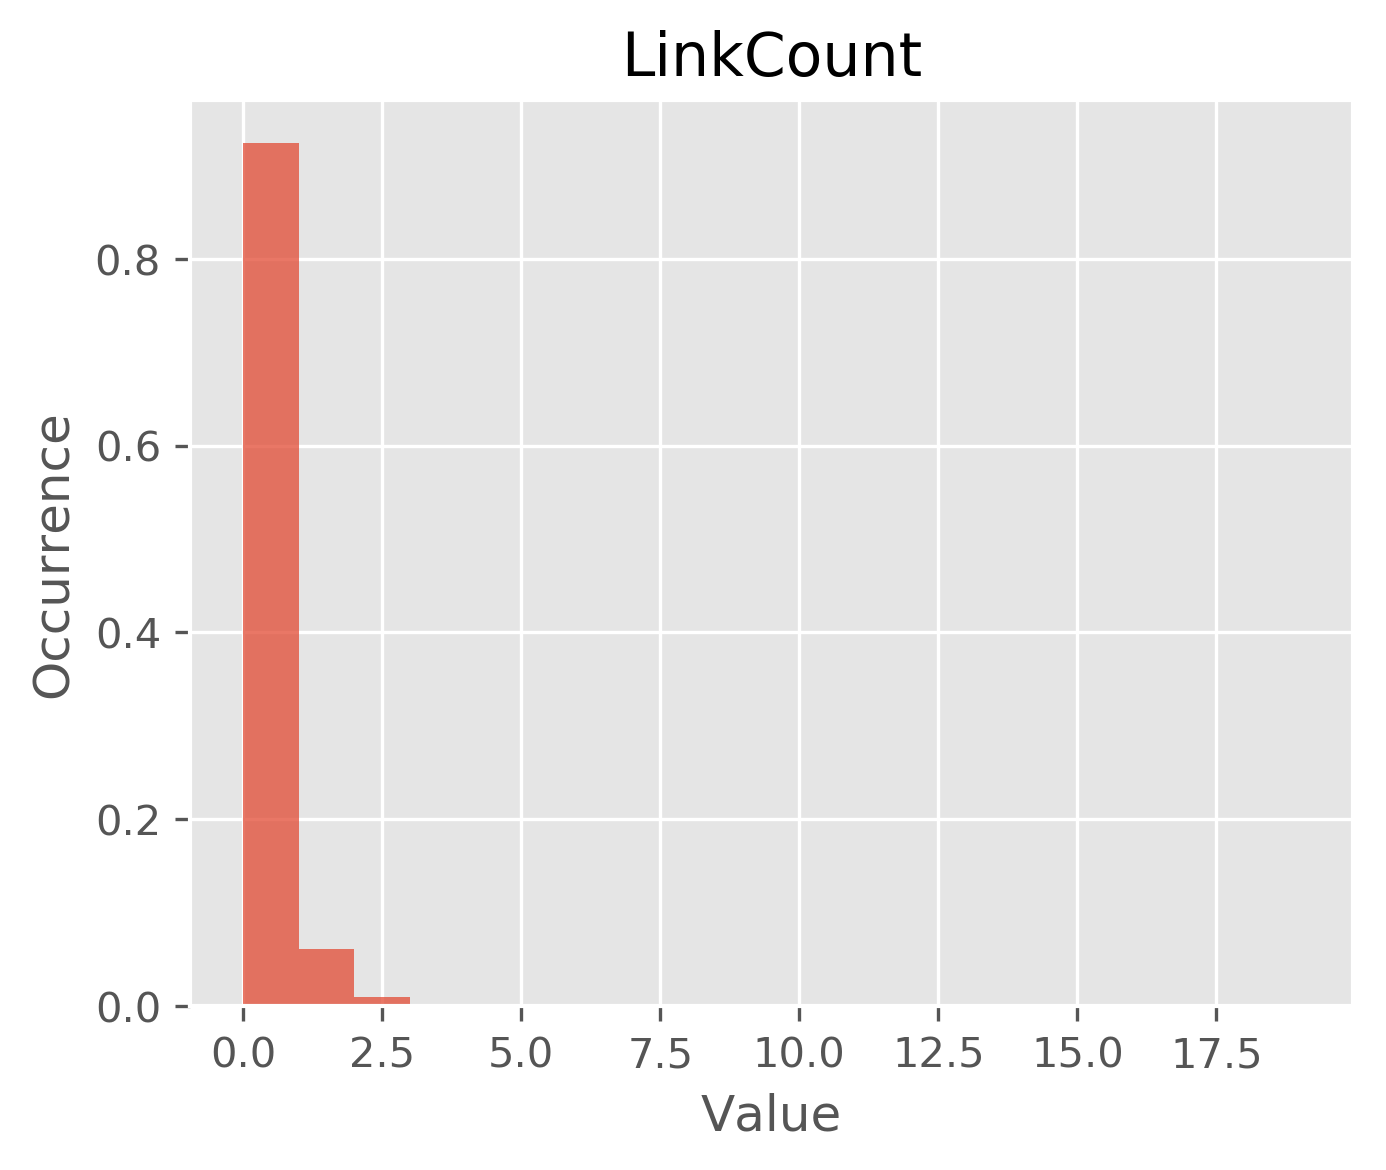

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])

plt.figure(figsize=(5,4), dpi=300) # width and height of the plot in inches

plt.title('LinkCount')
plt.xlabel('Value')
plt.ylabel('Occurrence')

n, bins, patches = plt.hist(X, normed=1, bins=range(max(X.ravel())-min(X.ravel())), alpha=0.75)

plt.grid(True)
save_png('01_feat_hist_LinkCount')

Ok, so most posts don't contain a link at all, but let's try nevertheless...

## Training on LinkCount

In [251]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

N_FOLDS = 10
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)

scores = []
for train, test in tqdm(cv.split(X, Y)):
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Mean(scores)=0.59960	Stddev(scores)=0.00861


# Using more features

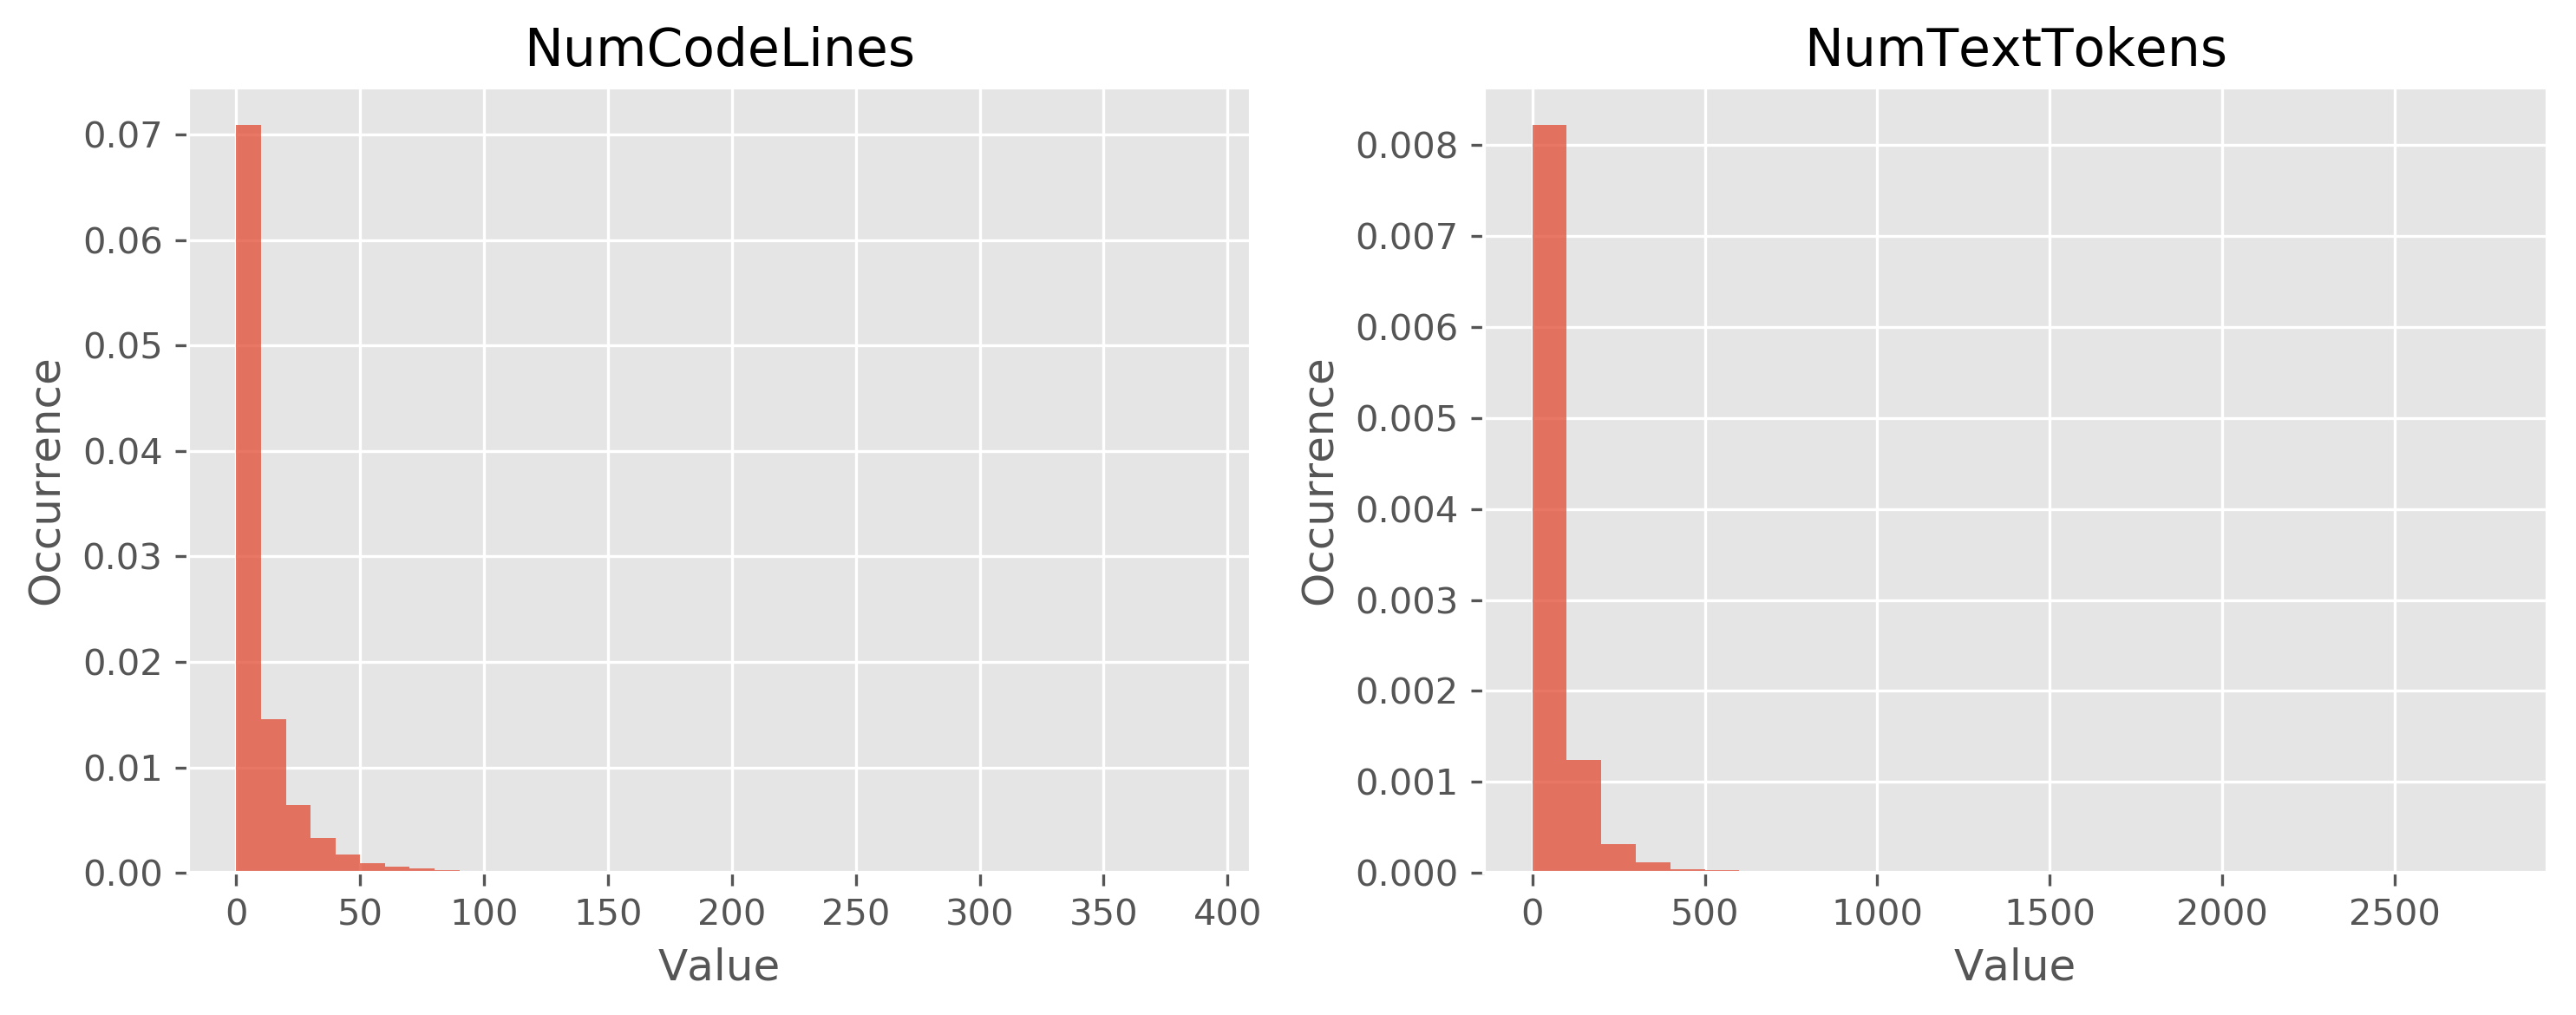

In [305]:
def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurrence')
            
            max_val = max(x.ravel())
            if max_val>1000:
                bins = range(0, max_val, 100)
            elif max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, normed=1, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()
    
    if not filename:
        filename = "feat_hist_%s" % name.replace(" ", "_")

    save_png(filename)


plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
                (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')],
              '02_feat_hist_CodeLines_TextTokens');

Since the features vary in their value ranges, we need to standardize them using `StandardScaler()` so that kNN does not bias towards features having larger value intervals. 

In [249]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Mean(scores)=0.60070	Stddev(scores)=0.00759


# Designing more features
Let's create some more text based features like average sentence and word length, how many words are CAPITALIZED or contain exclamation marks.

We simply fetch the post texts, calculate the statistics and add them to the `meta` dictionary.

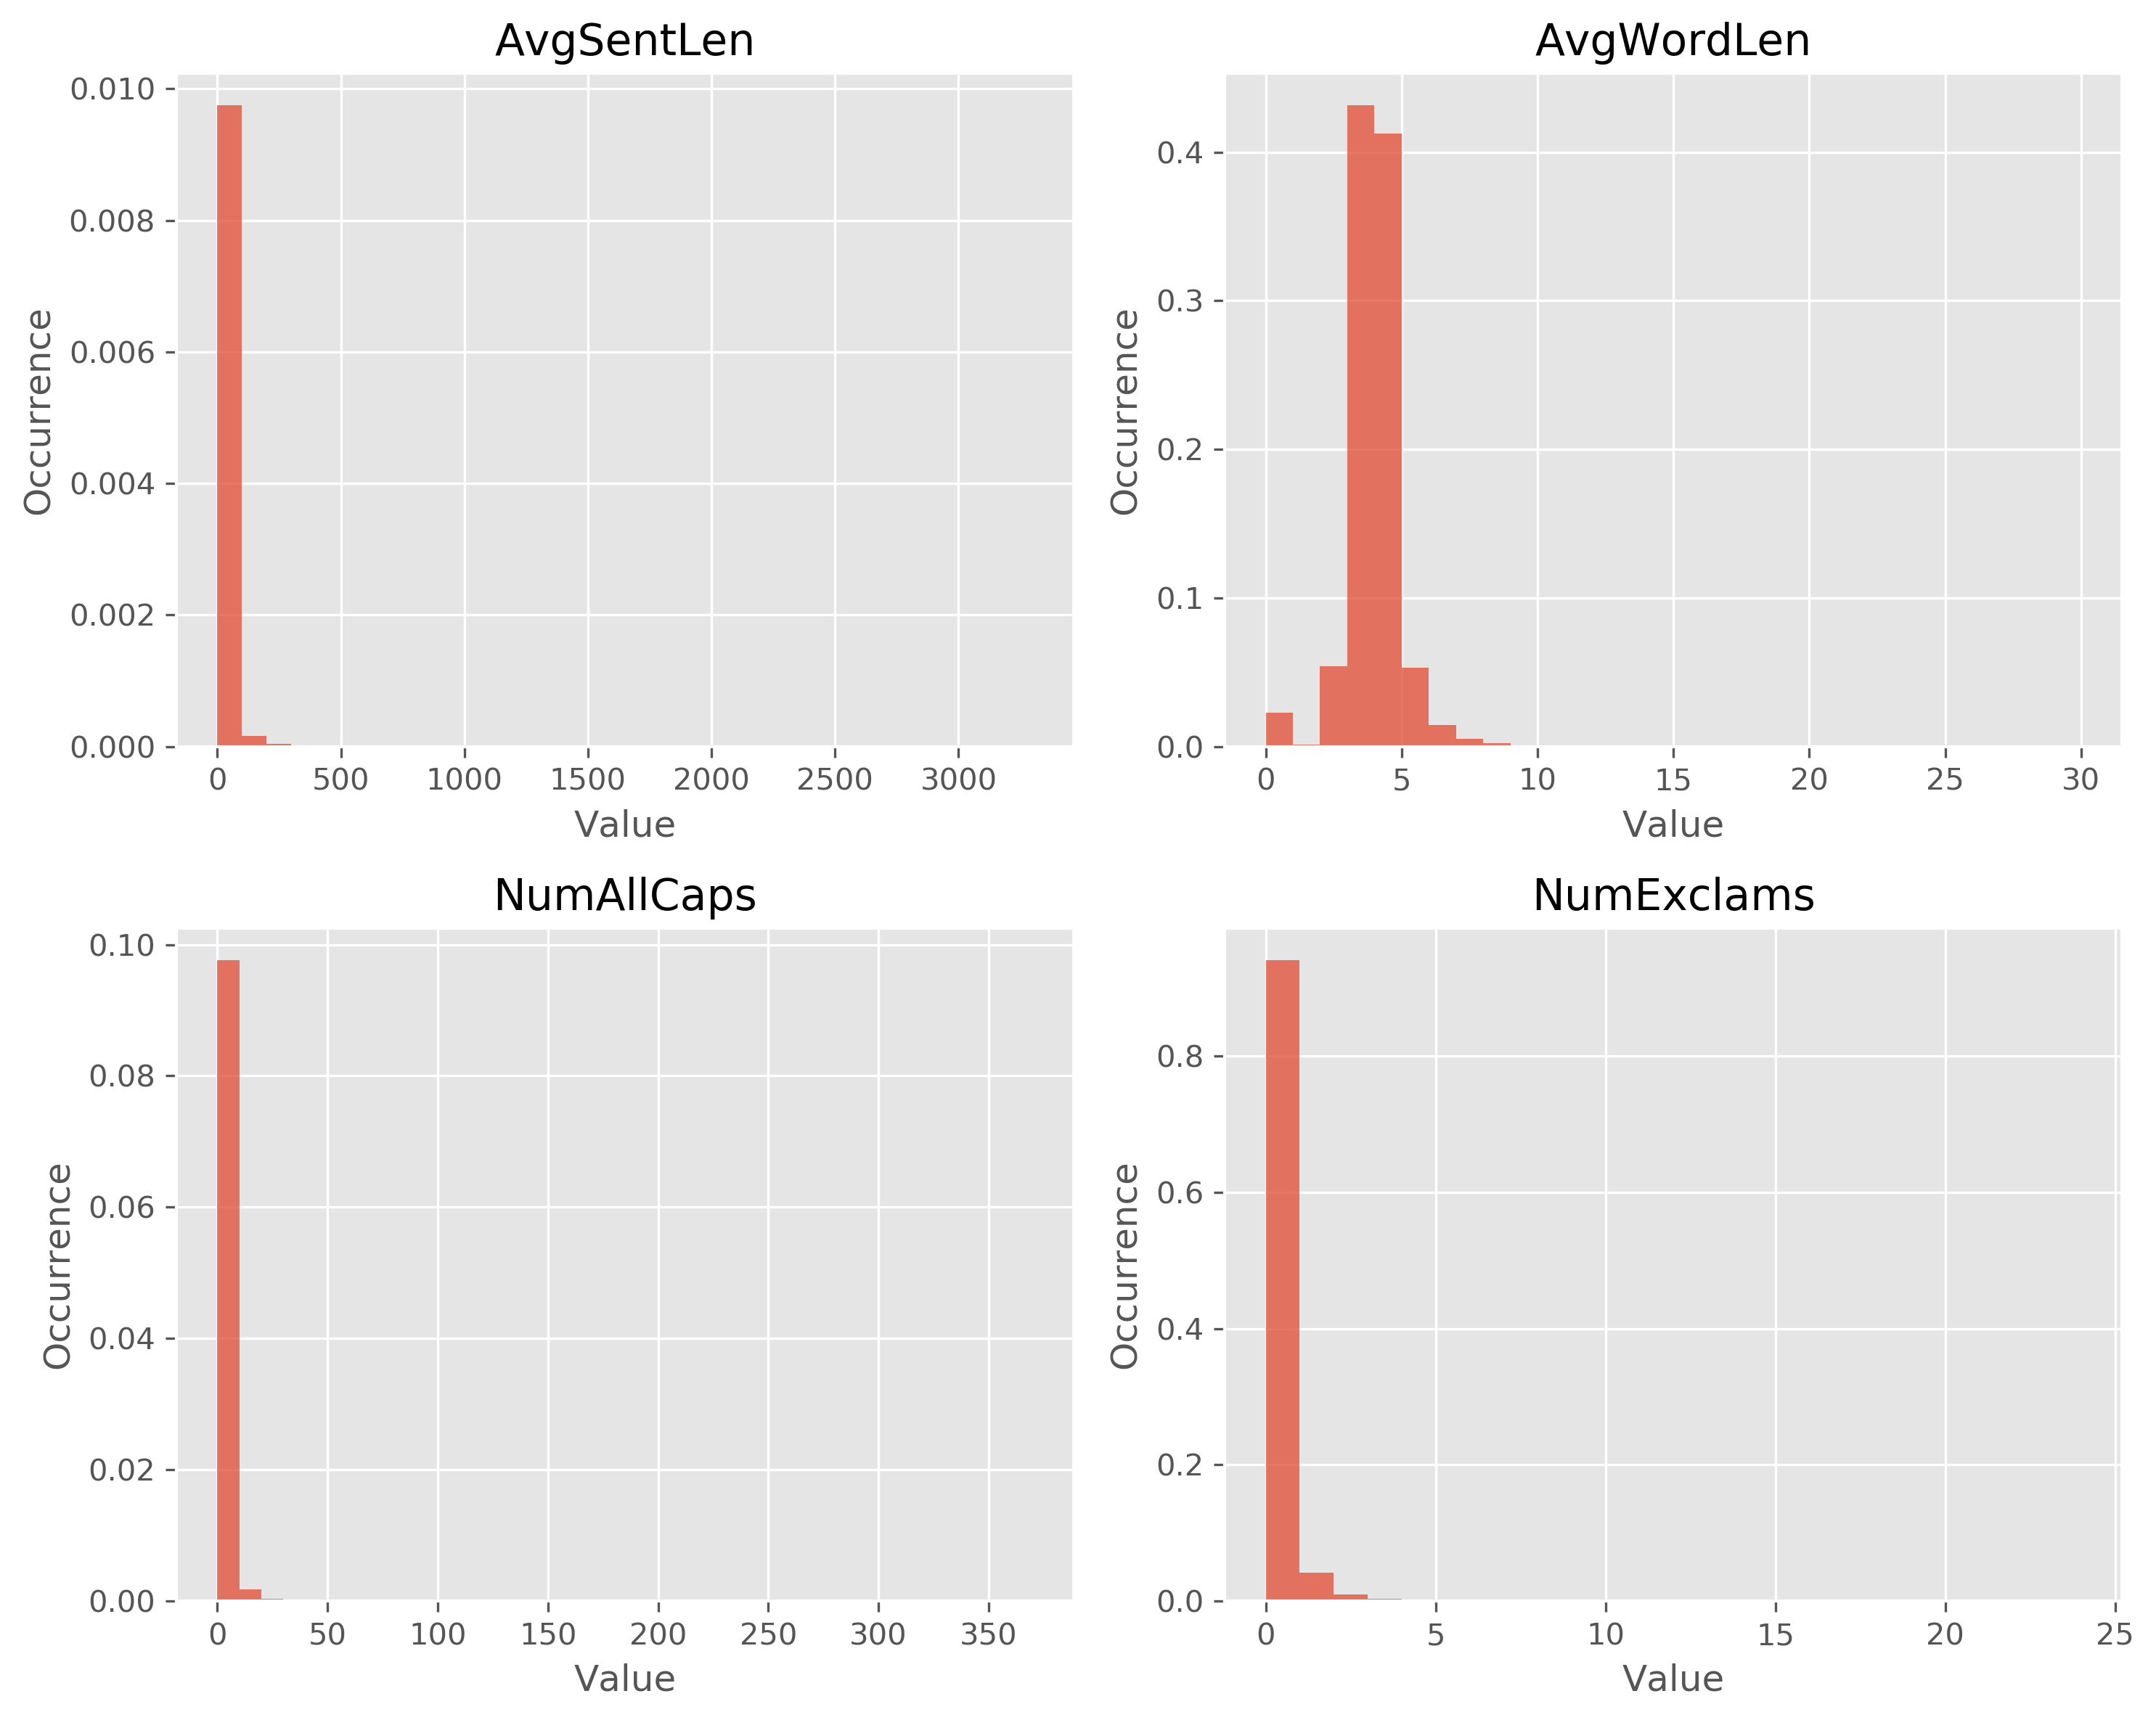

In [368]:
import nltk

def fetch_posts(fn):
    for line in open(fn, 'r', encoding='utf-8'):
        post_id, text = line.split('\t')
        yield int(post_id), text.strip()

def add_sentence_features(m):
    for pid, text in fetch_posts(fn_sample):
        if not text:
            for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
                m[pid][feat] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']],
              '03_feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams');

In [258]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 
                                   'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):    
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Mean(scores)=0.60225	Stddev(scores)=0.00729


# High or low bias?

In [339]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title("Bias-Variance for '%s'" % name)
    plt.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")+'_pr'
    save_png(filename)

def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1, alpha=0.75)

    plt.title('Feature importance for %s' % (name.split('_')[-1]))
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")+'_feat_imp'
    save_png(filename)

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv.split(X, Y)):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        if False:
            print("Clone #%i" % fold_idx)
            print(classification_report(y_test, proba[:, label_idx] >
                  threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    # print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], plot + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)
        elif hasattr(clf, 'named_steps'):
            for step, s_clf in clf.named_steps.items():
                if hasattr(s_clf, 'coef_'):
                    plot_feat_importance(feature_names, s_clf, name)

    summary = {'name': name,
               'scores': scores,
               'roc_scores': roc_scores,
               'pr_scores': pr_scores,
               'med_precisions': precisions[medium], 
               'med_recalls': recalls[medium], 
               'med_thresholds': thresholds[medium]}
    
    return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(40, 2000, 20)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)

As we have learned in the previous chapter, when using features with different value ranges, it helps to standardize them.

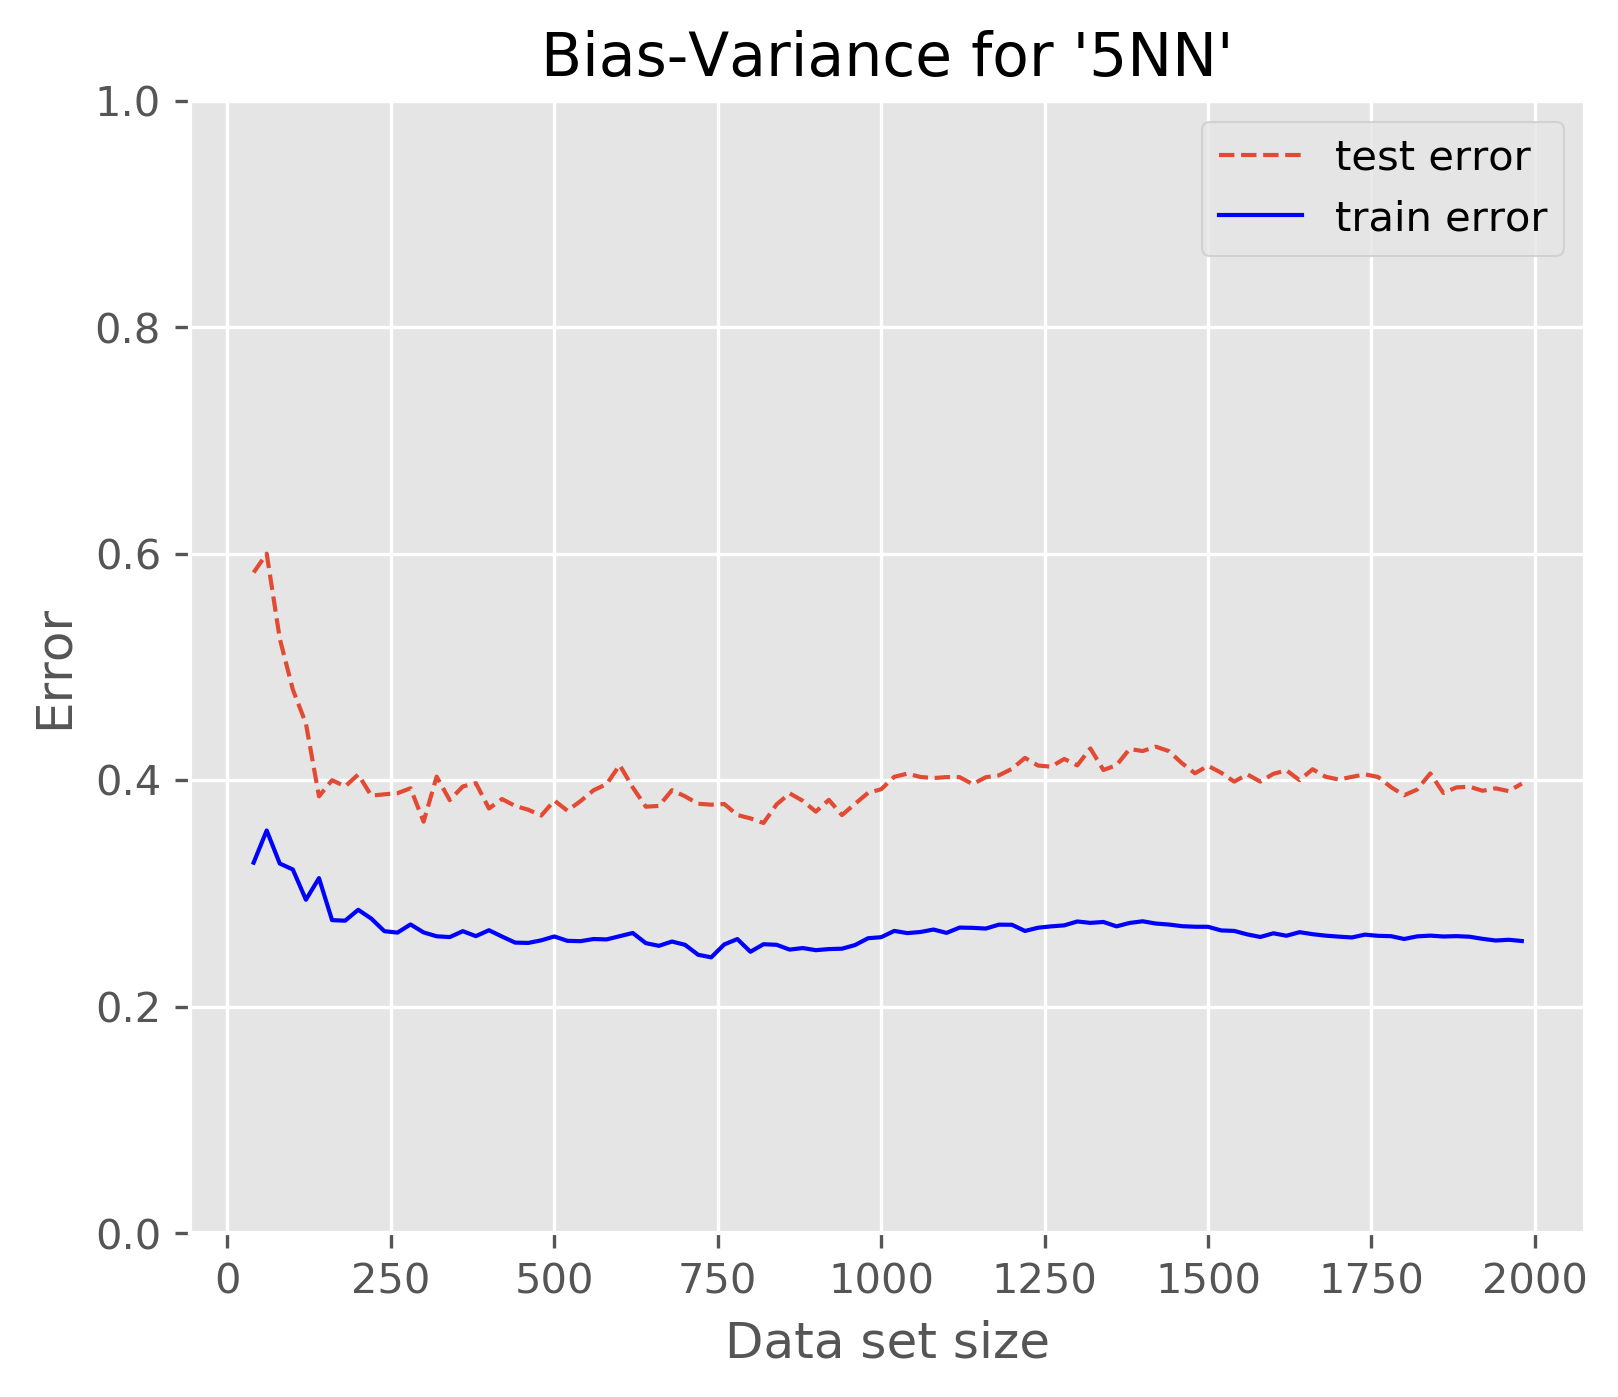

In [259]:
def create_pipeline(**param):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X, Y)
save_png('04_bv_5NN_all')

Maybe simplifying the feature space helps. Let's try out to use only `LinkCount` and `NumTextTokens`:

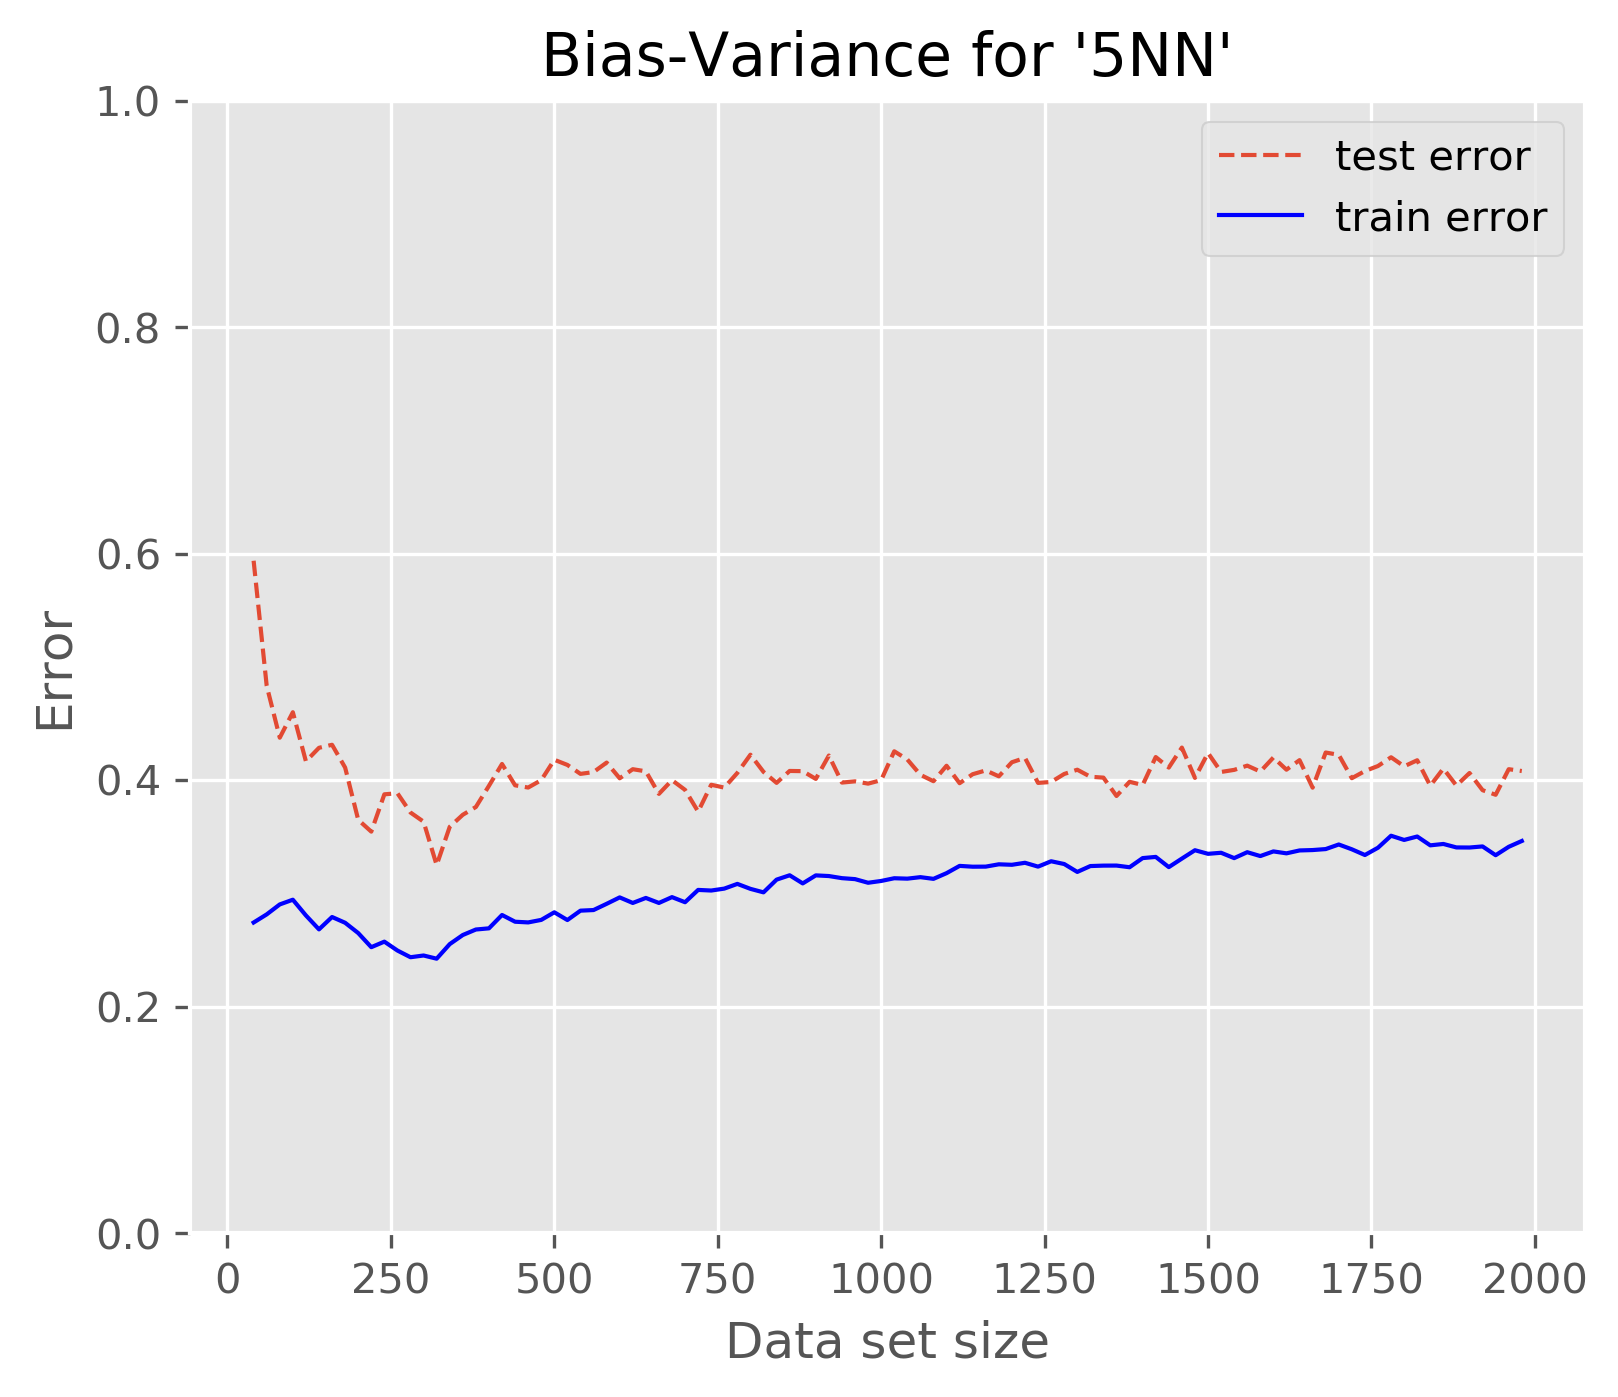

In [260]:
X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers], float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state=0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)
save_png('05_bv_5NN_simp')

Does it help to reduce the model complexity by increasing $k$?

In [332]:
print('k\tmean(scores)\tstddev(scores)')
for k in [5, 10, 40]:
    _, _, summary = measure(create_pipeline, {'n_neighbors': k}, "%iNN" % k, X, Y)
    print('%d\t%.4f\t\t%.4f' % (k, np.mean(summary['scores']), np.std(summary['scores'])))

k	mean(scores)	stddev(scores)
5	0.6022		0.0073
10	0.6191		0.0096
40	0.6425		0.0104


It helps a bit, but do we really want to compare with 40 different samples each time?

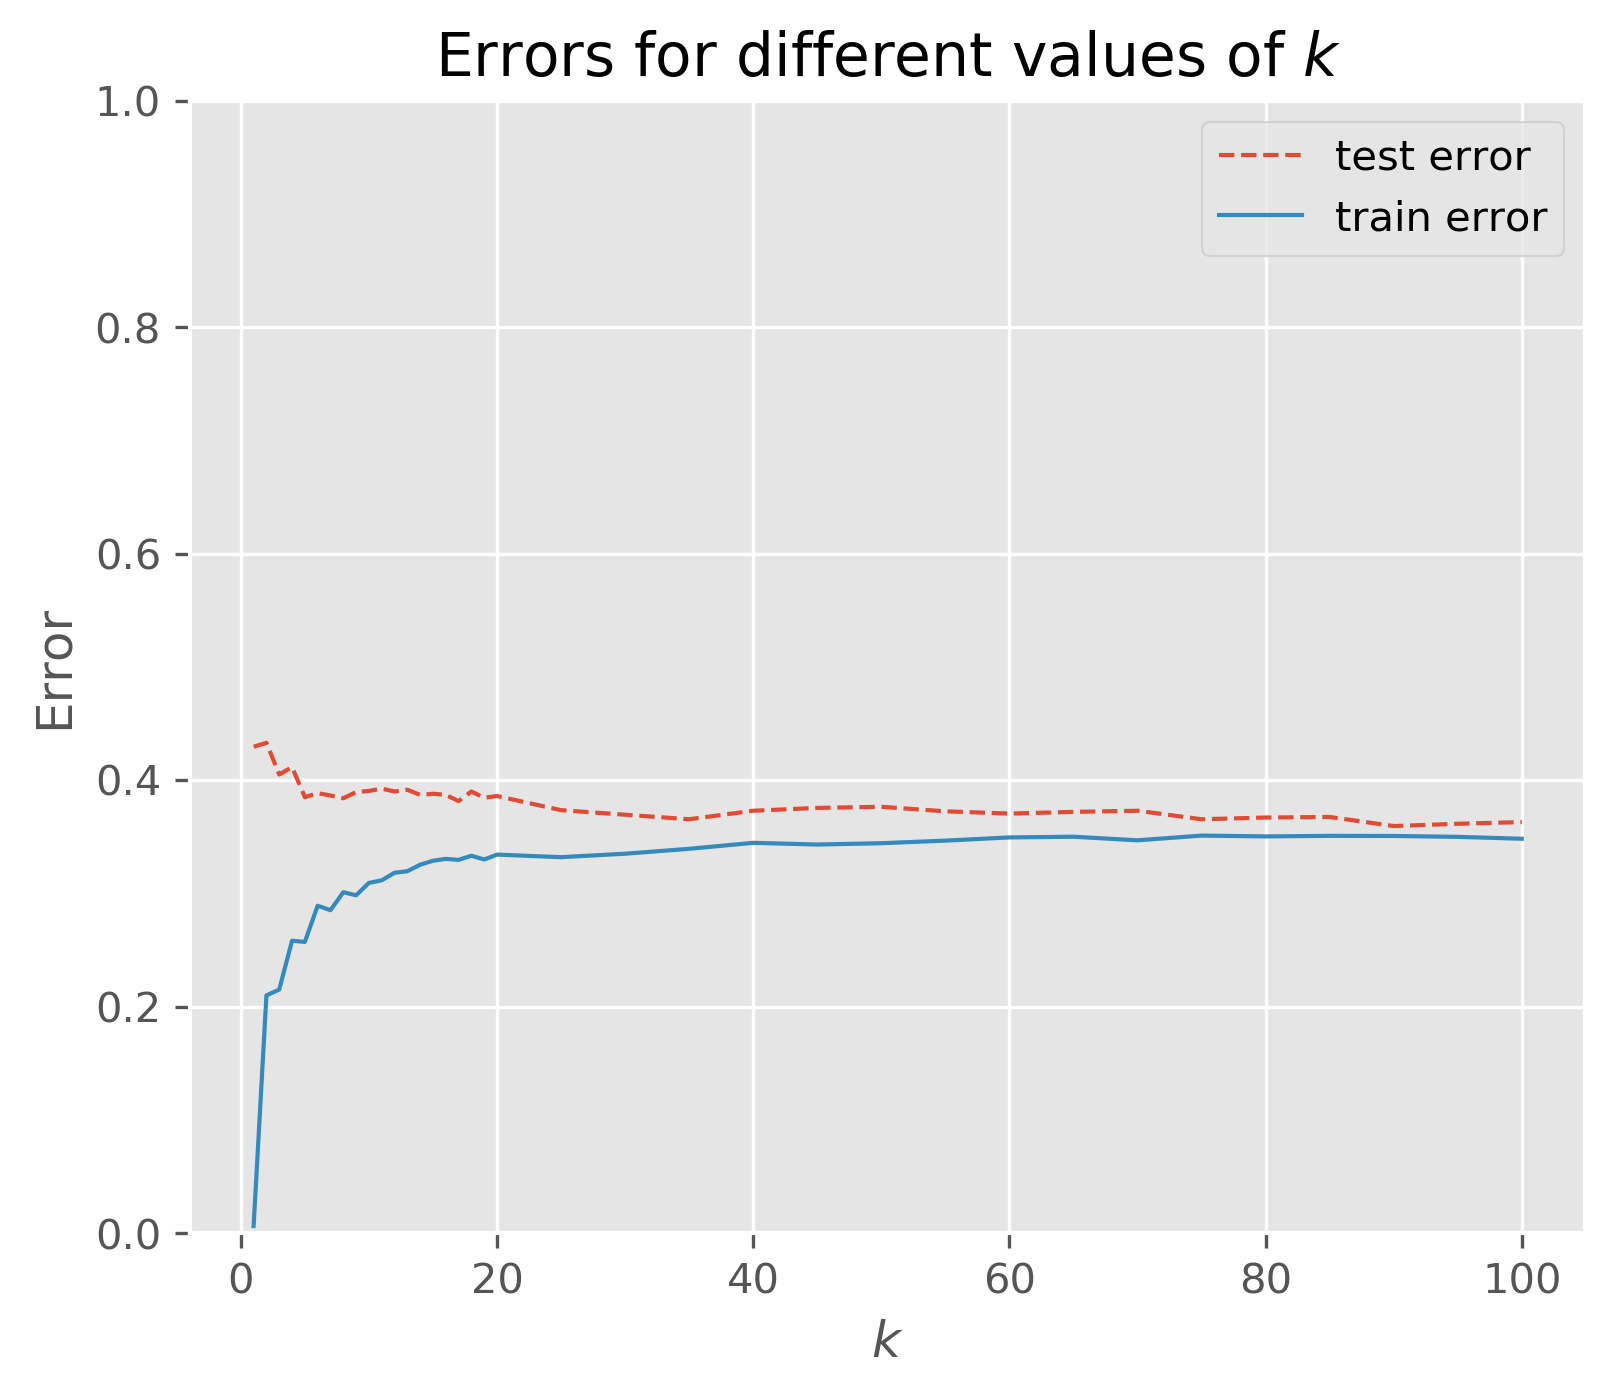

In [263]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)
    save_png('06_kcomplexity')

def k_complexity_analysis(clf_class, X, Y):
    # Measure for different k's: [1,2,..,20,25,..,100]
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, "%dNN" % k, X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)


k_complexity_analysis(create_pipeline, X, Y)    

And we won't get much better with increasing values of $k$.

# Using logistic regression
Creating some toy data to visualize how logistic regression works...

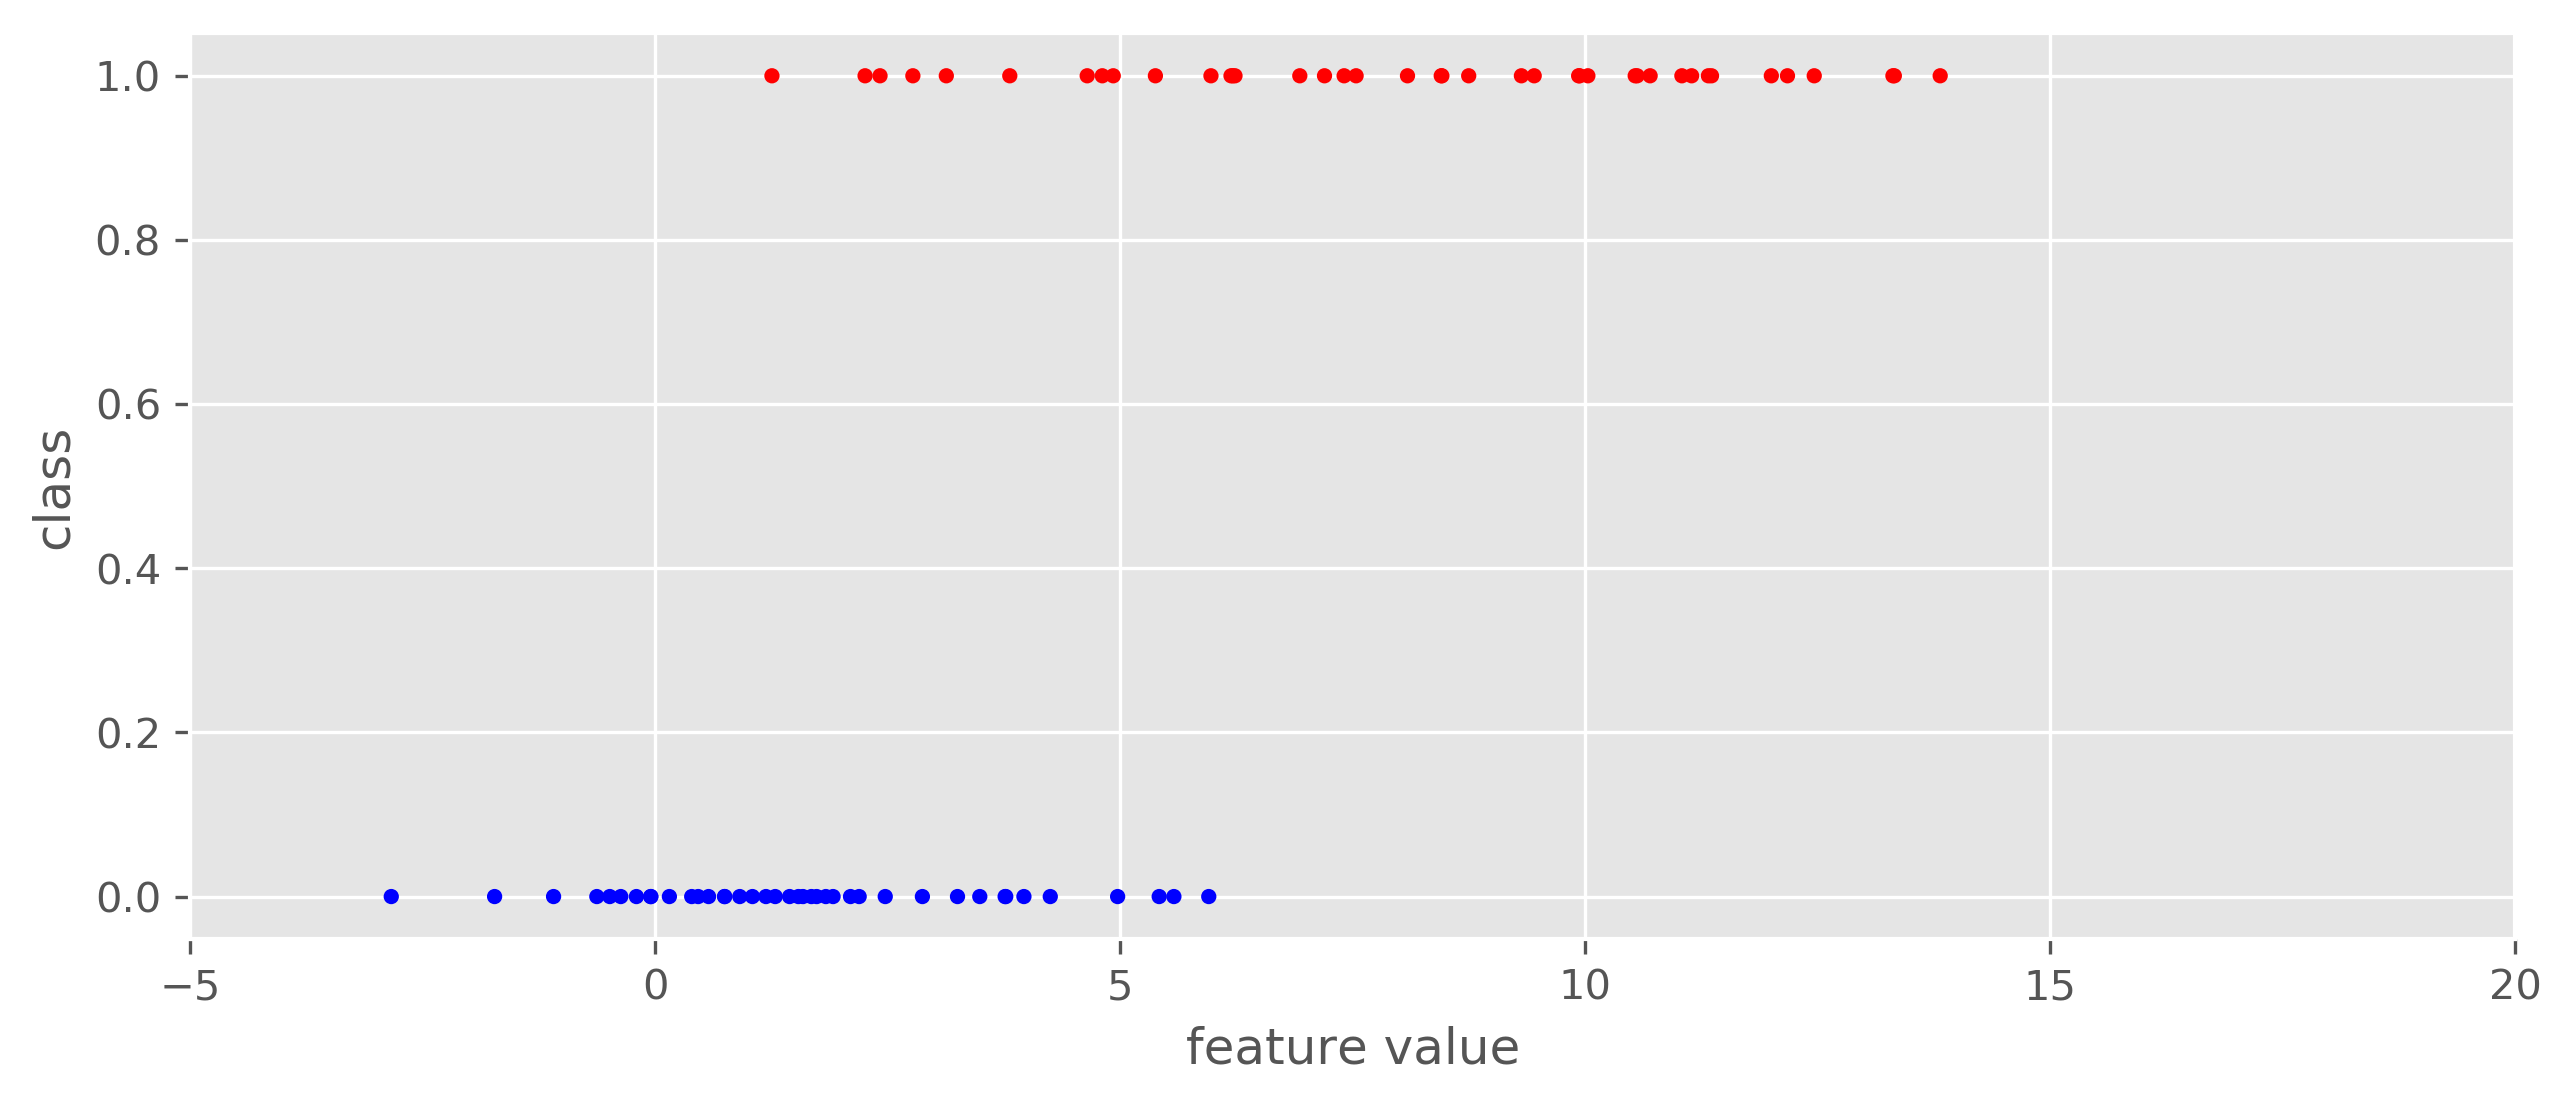

In [293]:
from scipy.stats import norm

np.random.seed(3)

NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2), norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS), np.ones(NUM_PER_CLASS))).astype(int)

plt.figure(figsize=(10, 4), dpi=300)
plt.grid(True)

plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=10)
plt.xlabel("feature value")
plt.ylabel("class")
save_png('06_log_reg_example_data')

In [289]:
from sklearn.linear_model import LogisticRegression

def lr_model(clf, X):
    '''
    https://en.wikipedia.org/wiki/Logistic_regression
    '''
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

logclf = LogisticRegression()
logclf.fit(X_log.reshape(NUM_PER_CLASS * 2, 1), y_log)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %(lr_model(logclf, -1), lr_model(logclf, 7)))

[ 0.09437188] [ 1.80094112]
P(x=-1)=0.05	P(x=7)=0.85


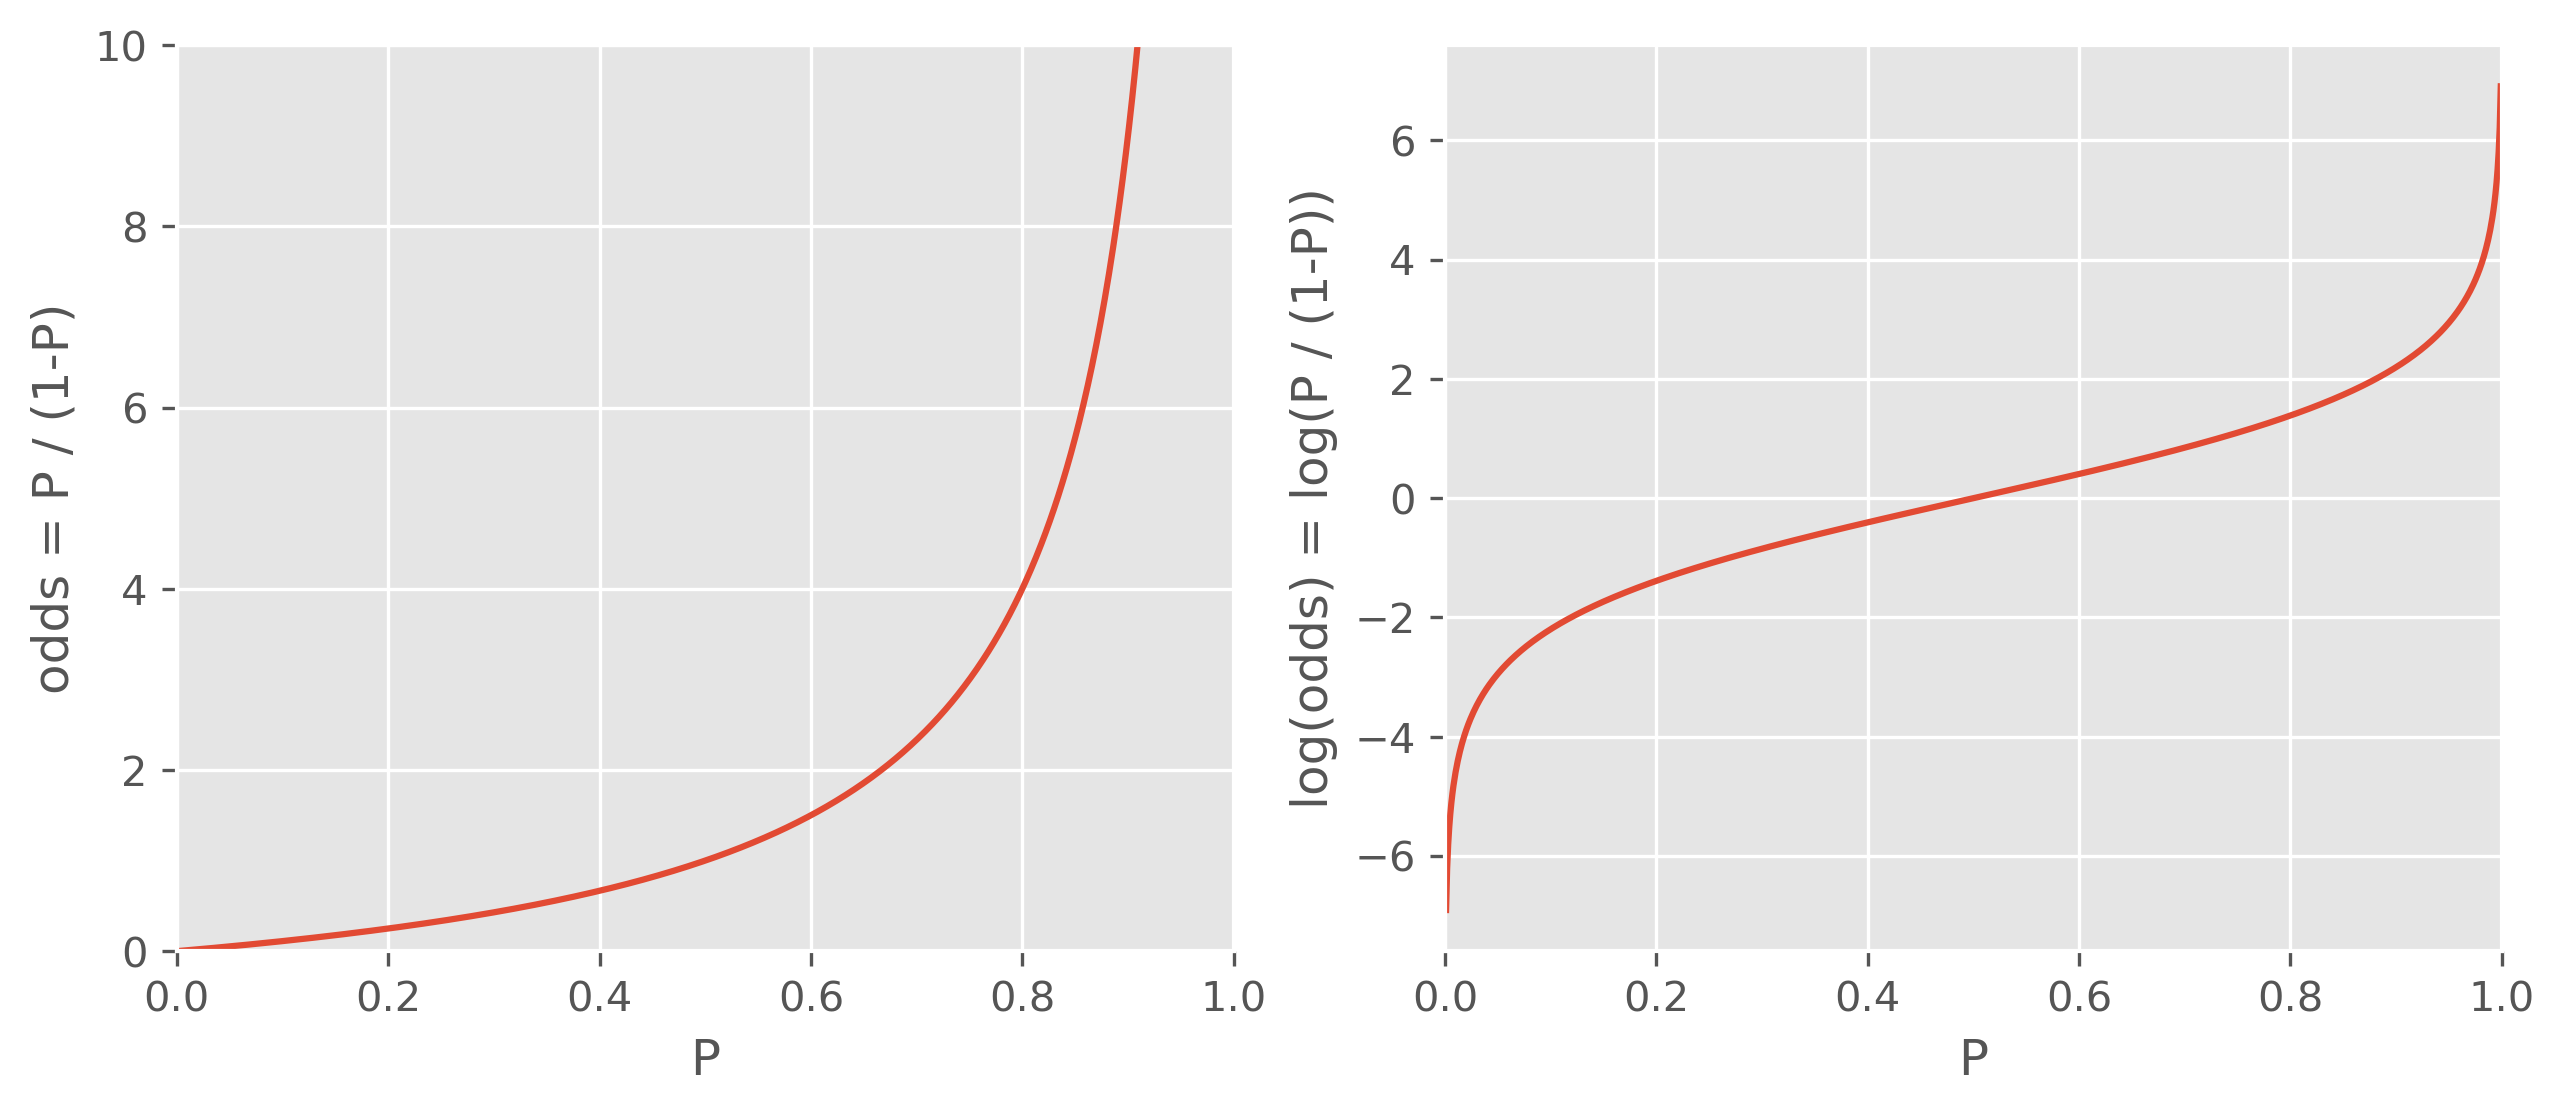

In [294]:
X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)
save_png('07_log_reg_log_odds')

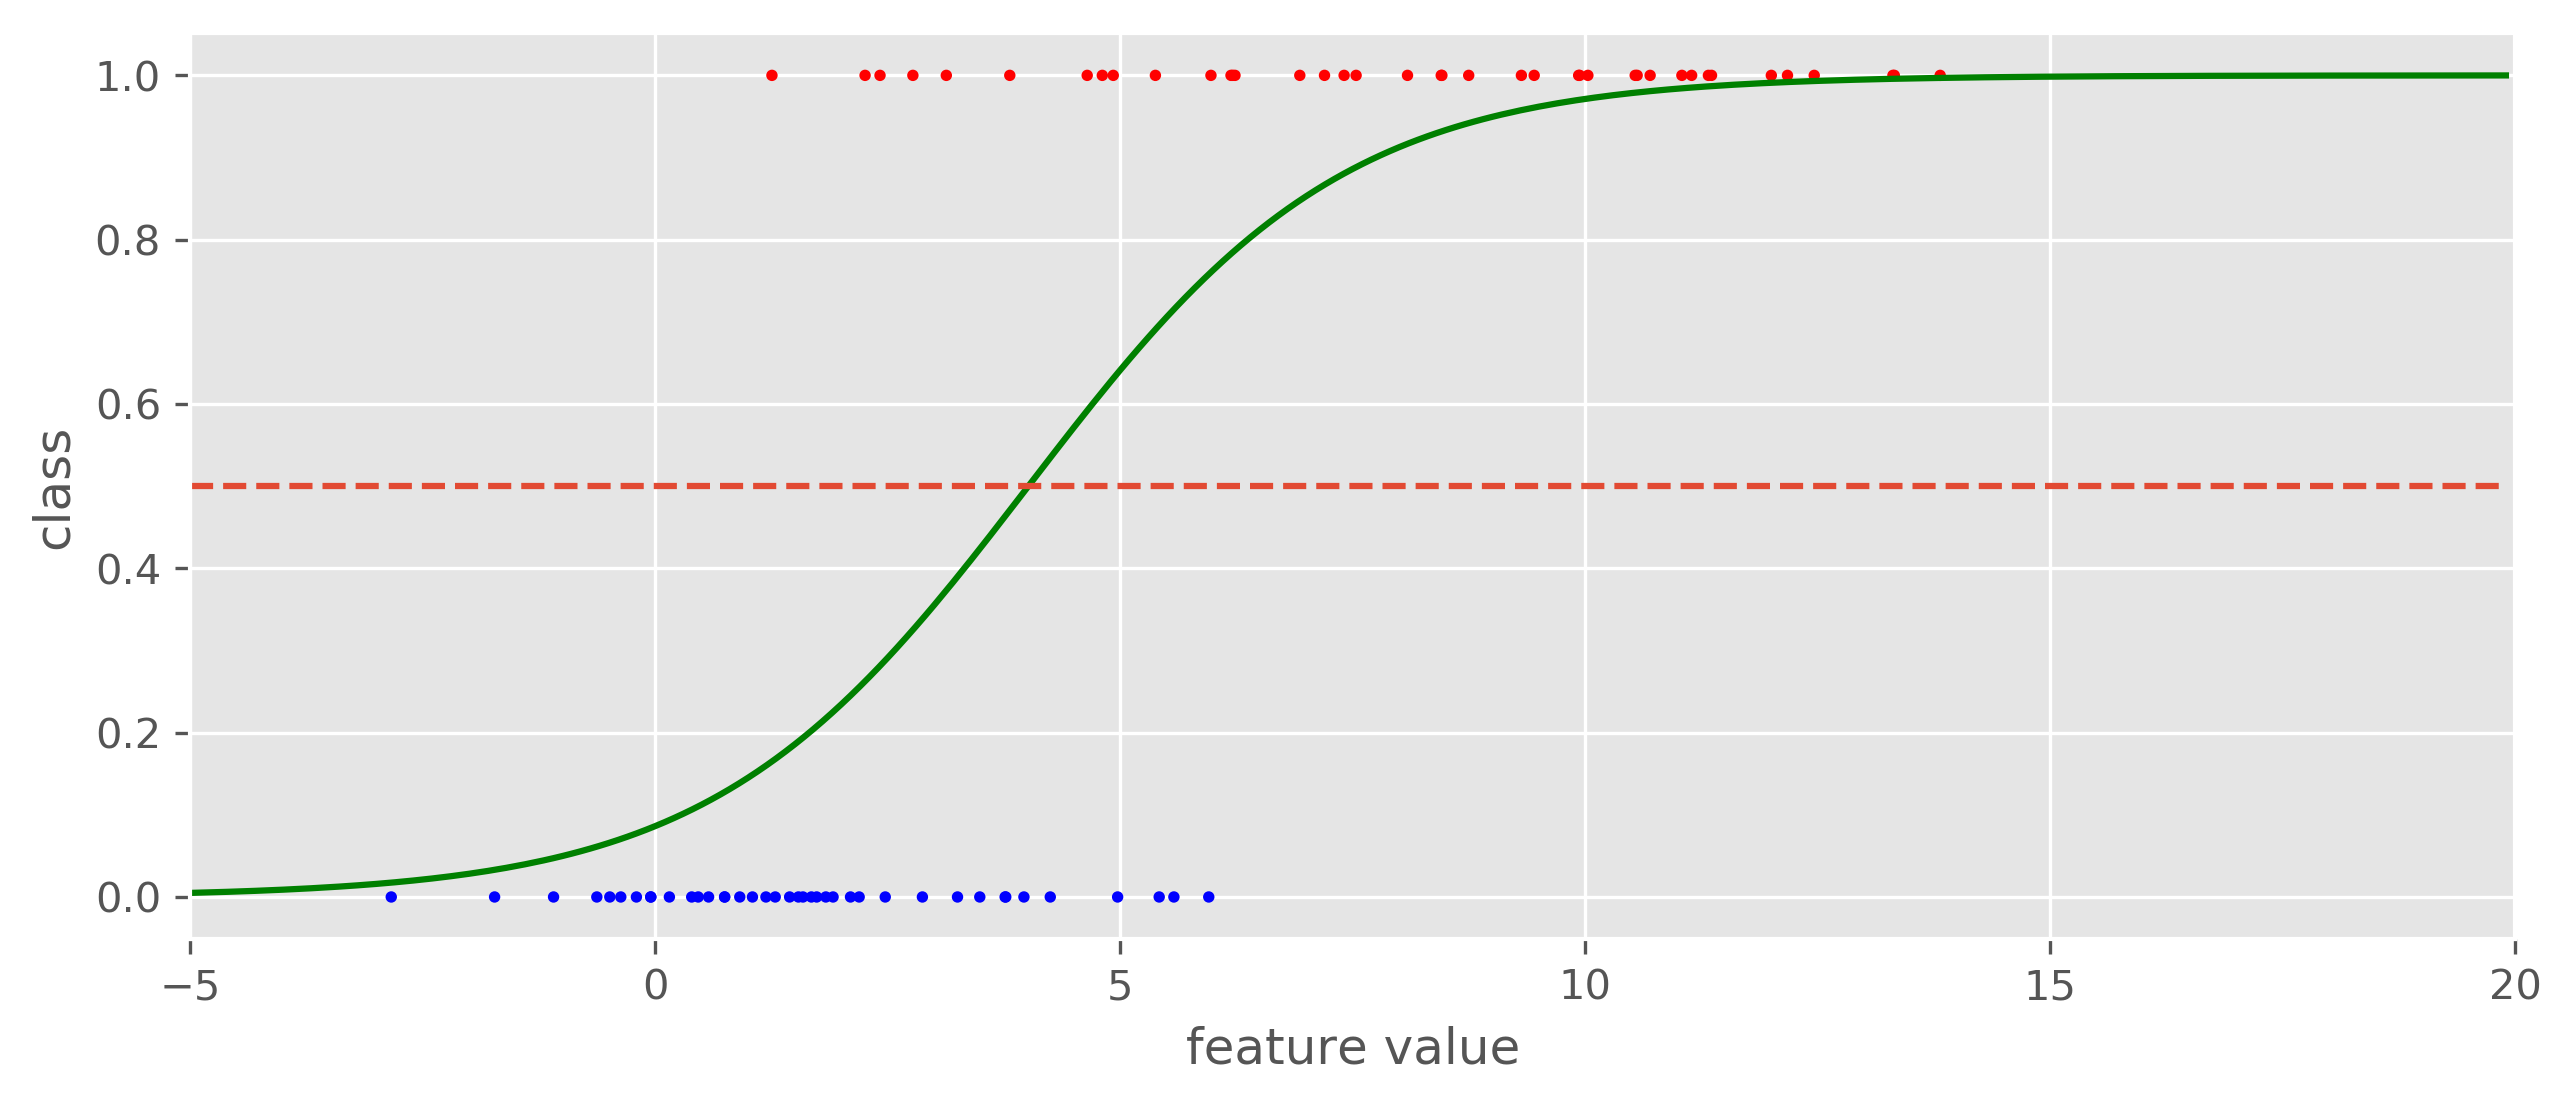

In [302]:
X_range = np.arange(-5, 20, 0.1)

plt.figure(figsize=(10, 4), dpi=300)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=5)
plt.plot(X_range, lr_model(logclf, X_range).ravel(), c='green')
plt.plot(X_range, np.ones(X_range.shape[0]) * 0.5, "--")
plt.xlabel("feature value")
plt.ylabel("class")
plt.grid(True)
save_png('08_log_reg_example_fitted')

# Applying logistic regression to our post classification problem

In [349]:
print('C\tmean(scores)\tstddev(scores)') 
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    _, _, summary = measure(LogisticRegression, {'C': C}, name, X, Y)

    print('%7.3f\t%.4f\t\t%.4f' % (C, np.mean(summary['scores']), np.std(summary['scores'])))

C	mean(scores)	stddev(scores)
  0.001	0.6369		0.0097
  0.010	0.6390		0.0109
  0.100	0.6382		0.0097
  1.000	0.6380		0.0099
 10.000	0.6380		0.0097


In [343]:
C_best = 0.01

# Looking behind accuracy – precision and recall 

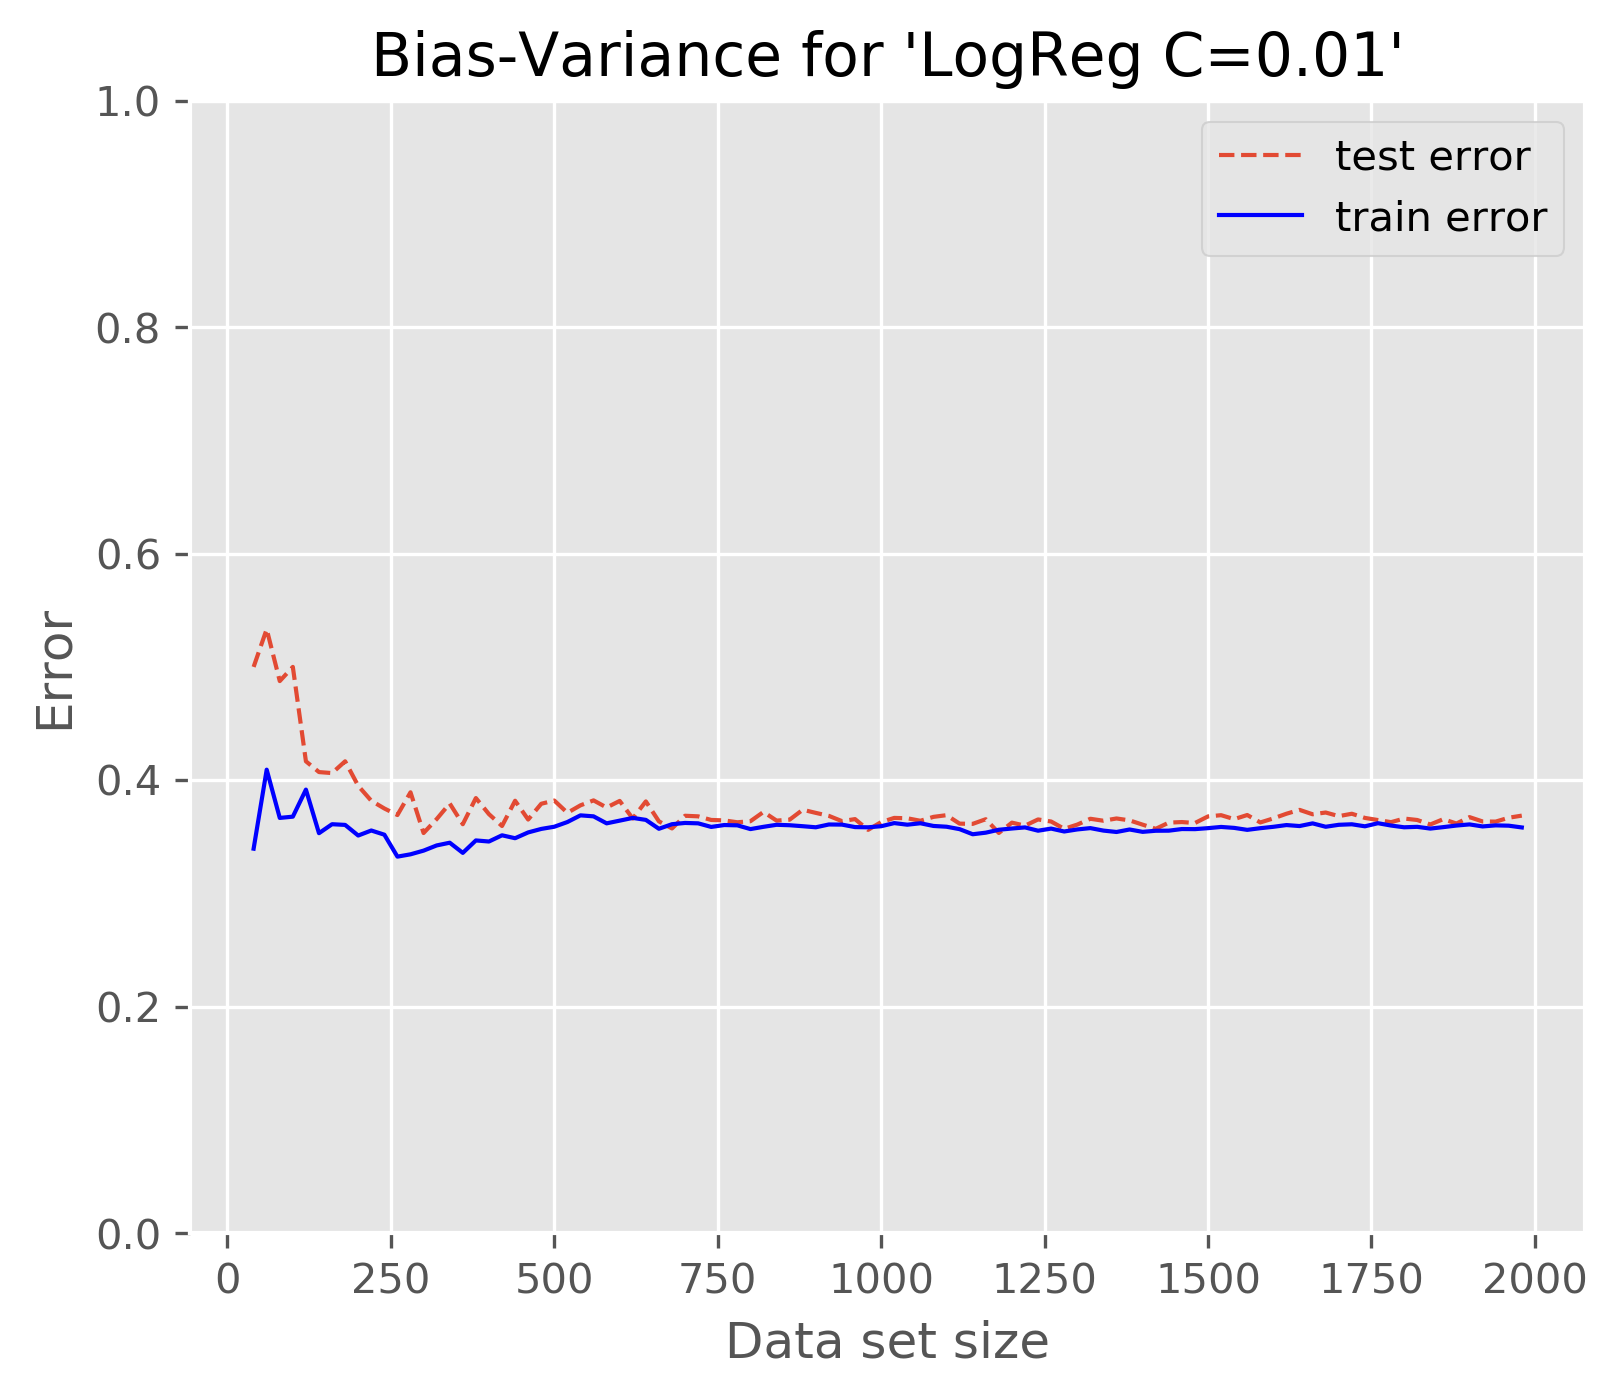

In [345]:
bias_variance_analysis(LogisticRegression, {'C': C_best}, "LogReg C=0.01", X, Y)
save_png('09_bv_LogReg')

Good answers...


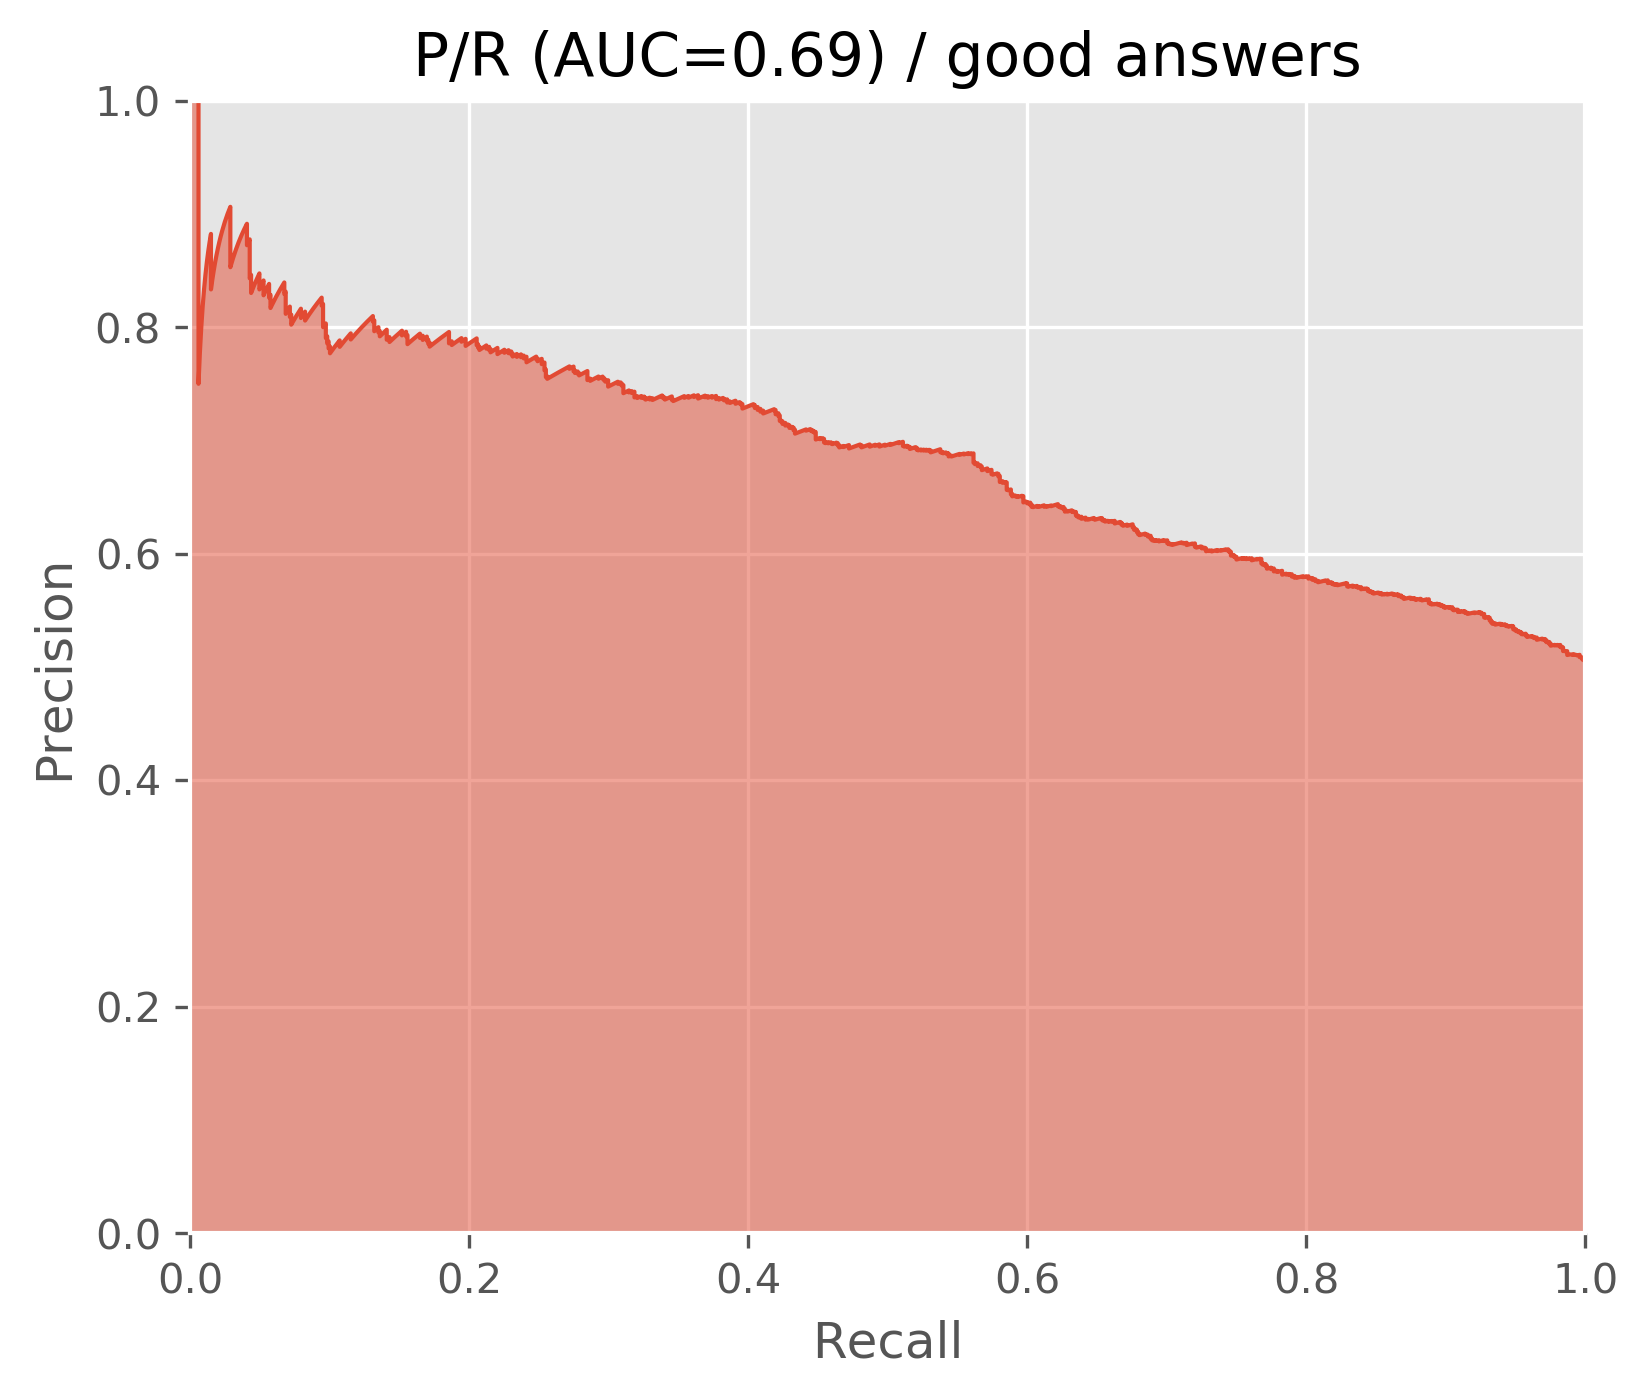

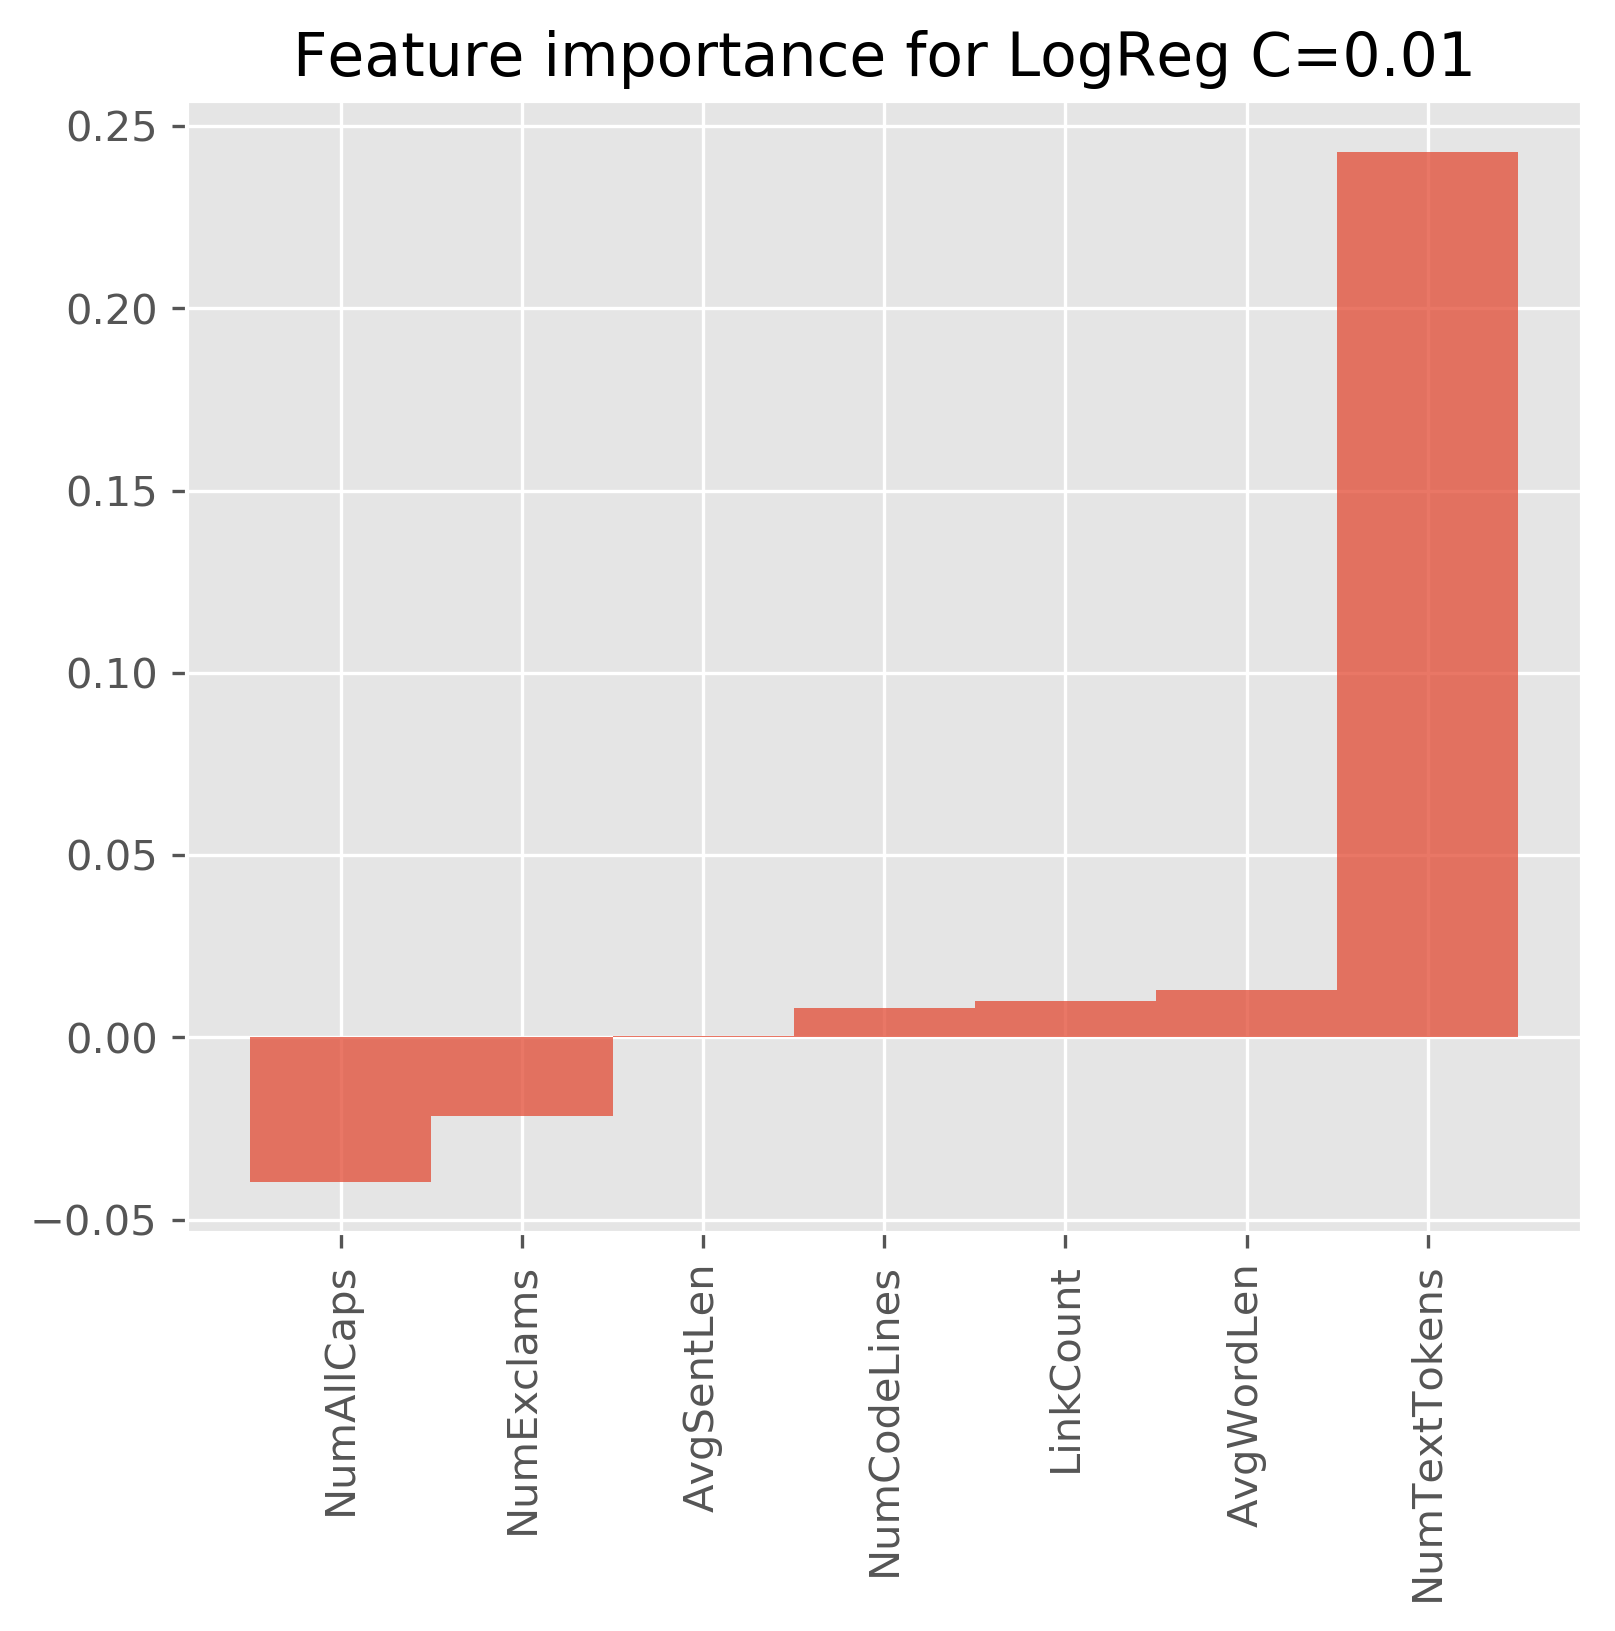

In [346]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams',
    'NumImages'
))

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor, random_state=0)
    
name = "LogReg C=%.2f" % C_best

print("Good answers...")
_, _, good_results = measure(LogisticRegression, {'C': C_best}, '08_good_'+name, X_new, Y_good, plot='good', feature_names=feature_names)

Poor answers...


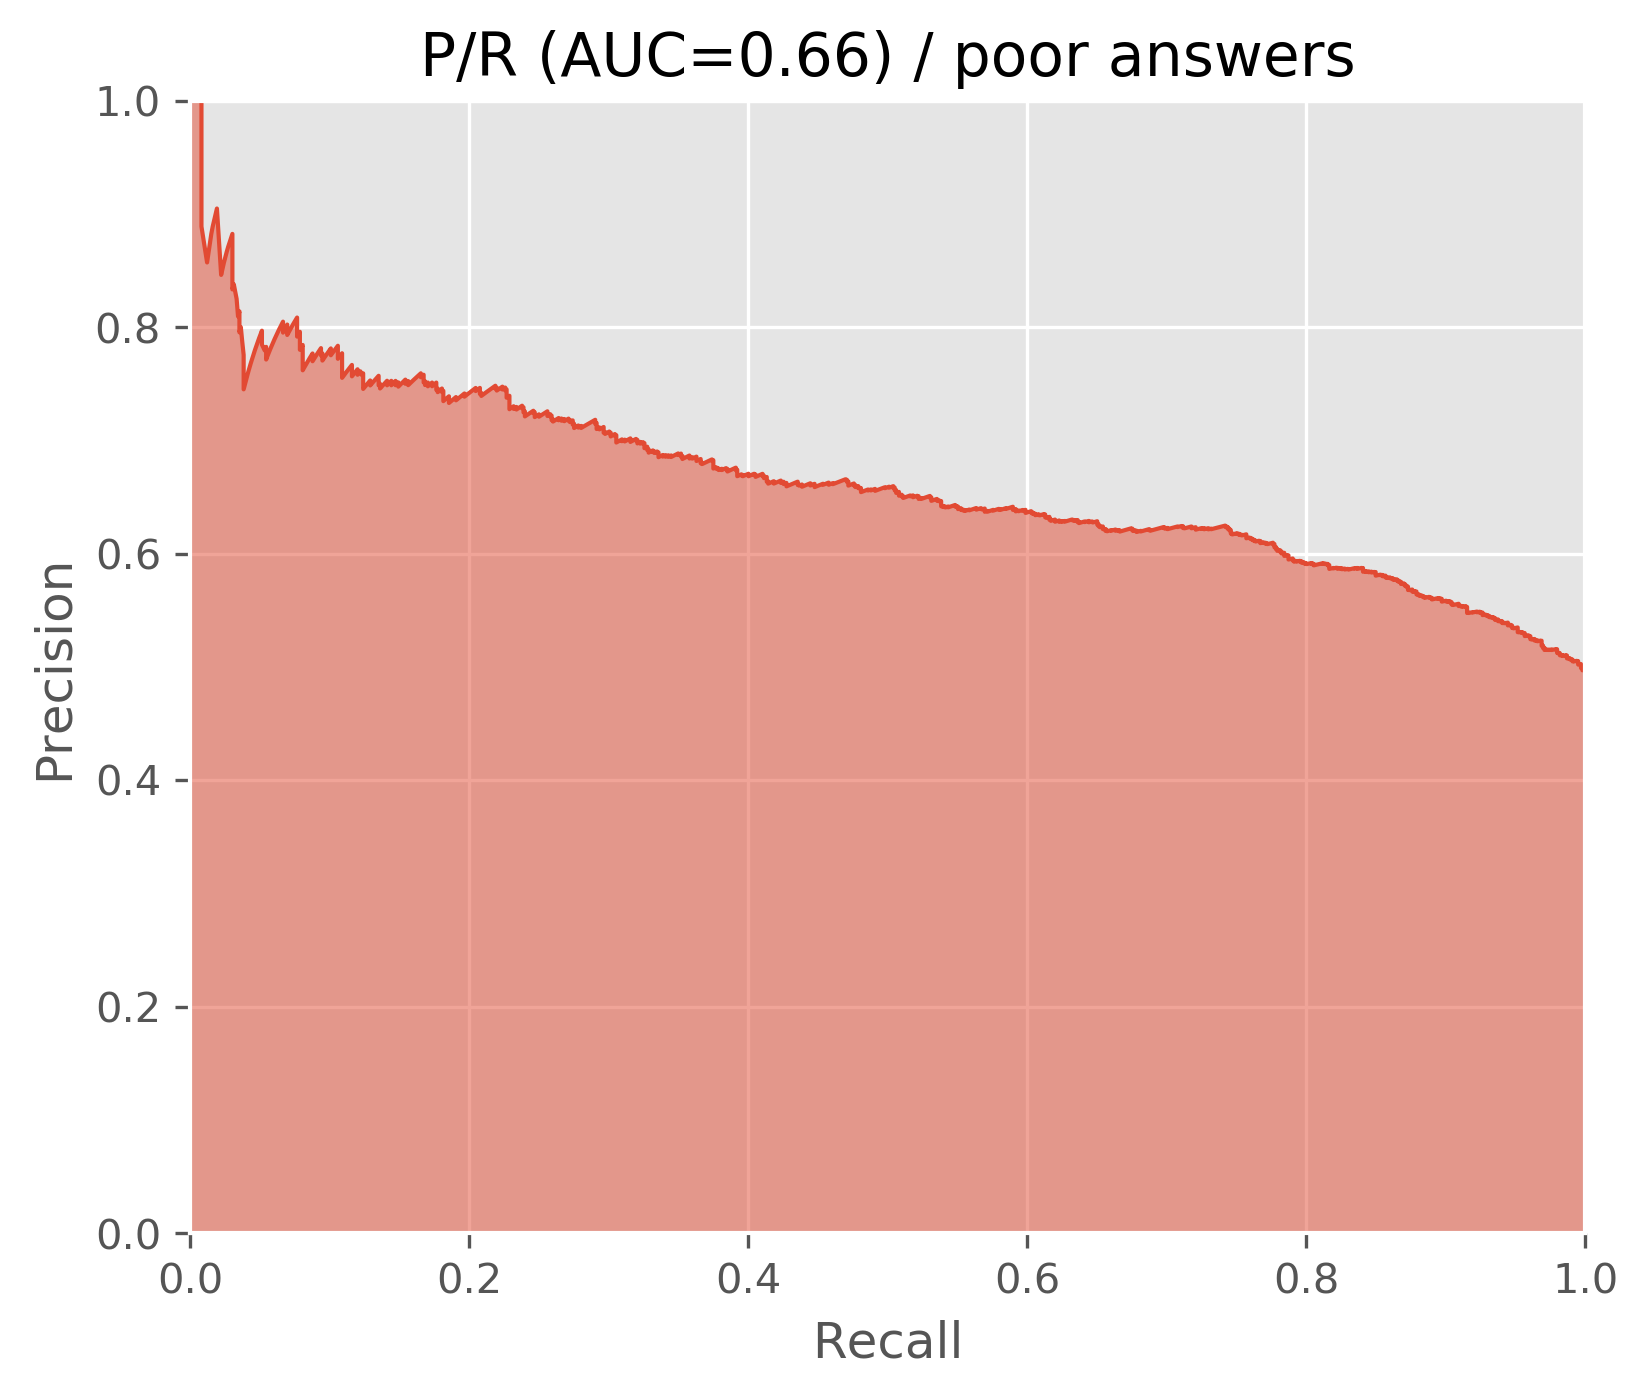

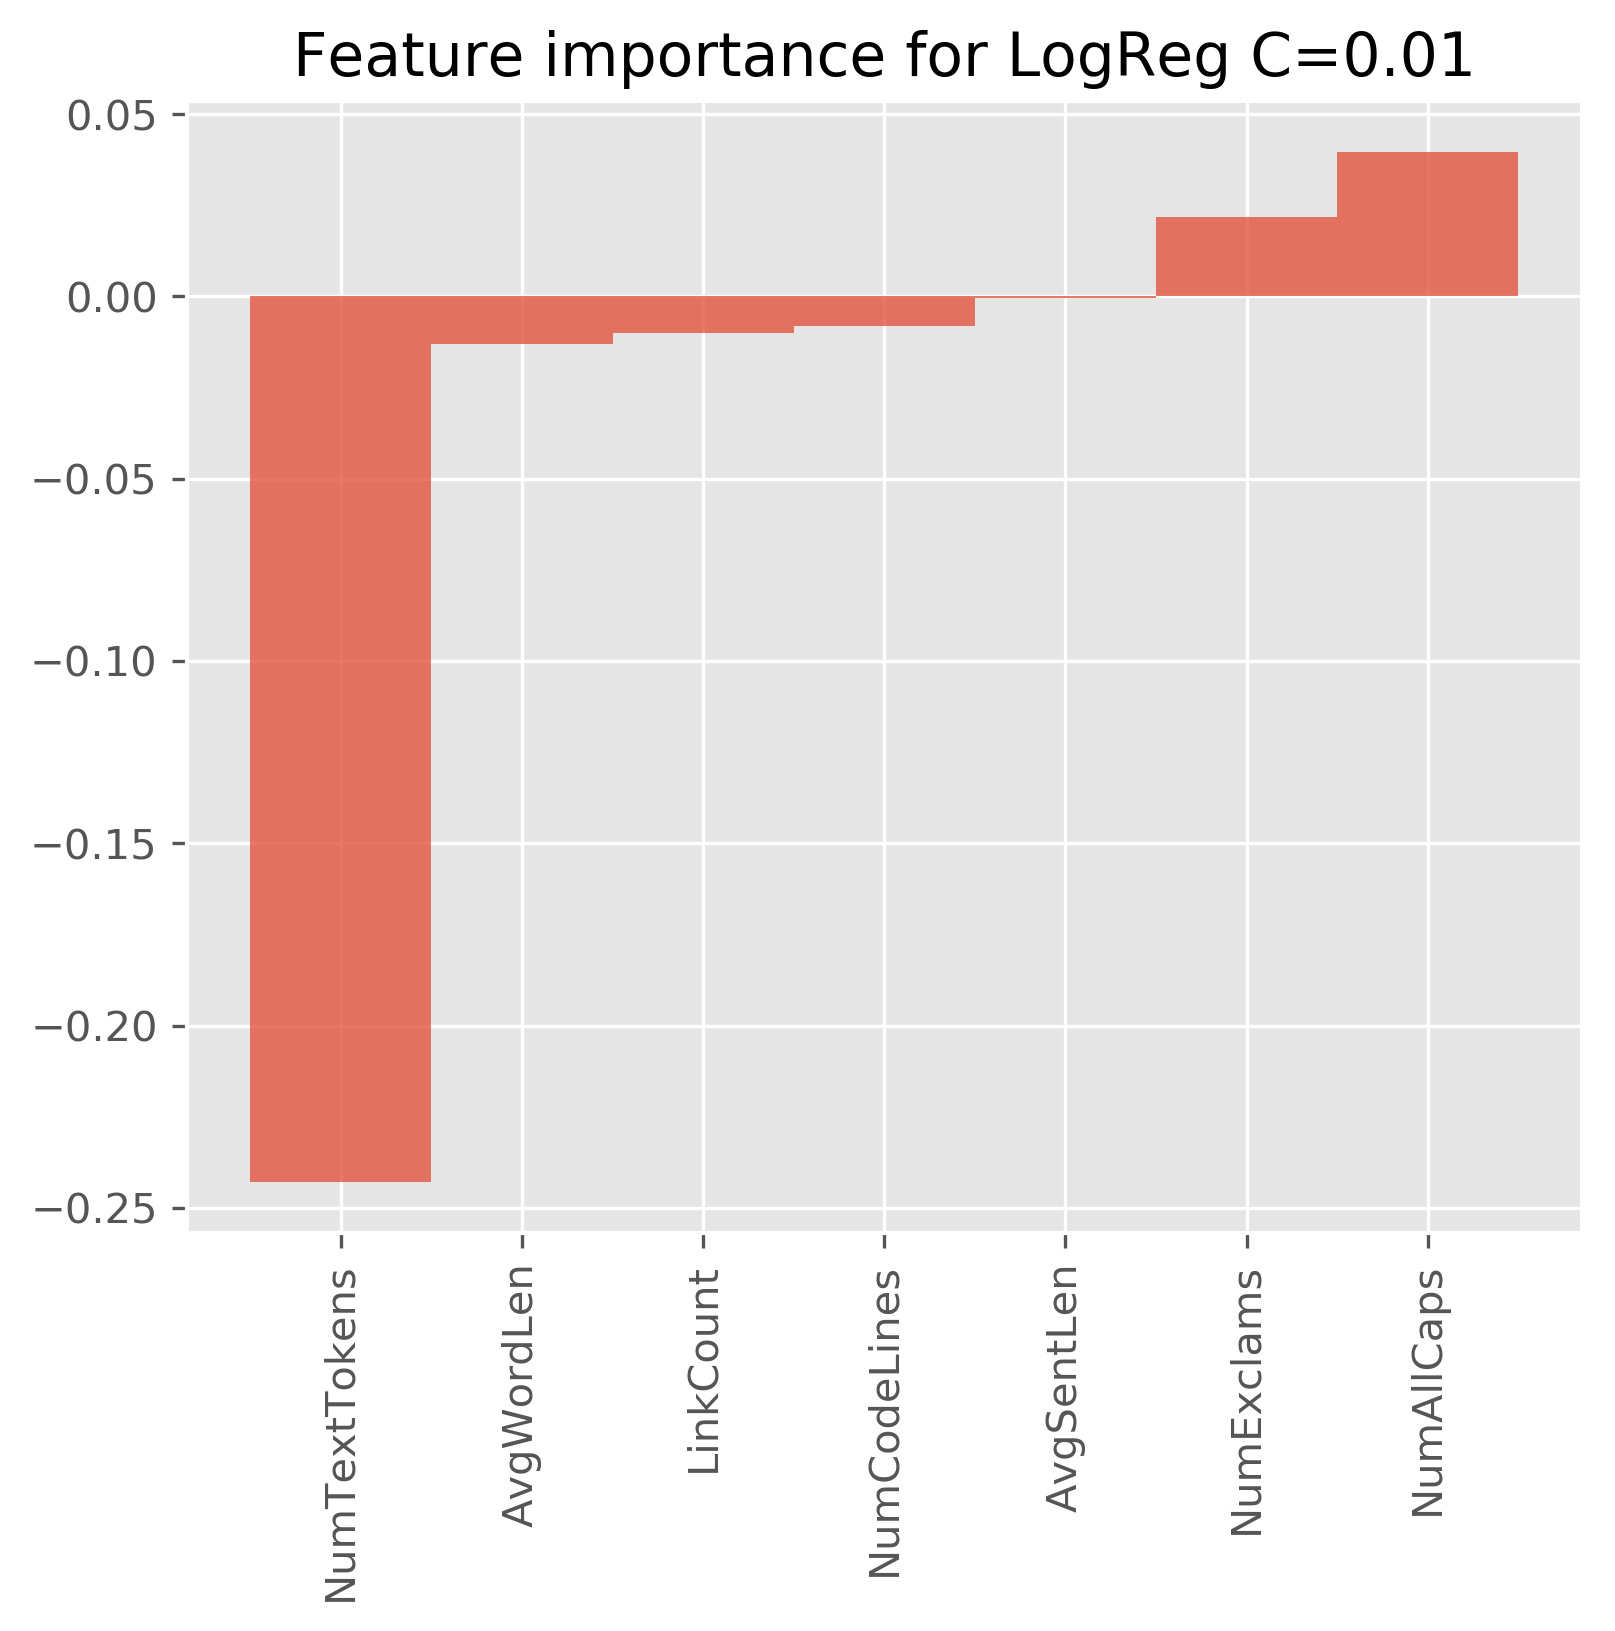

In [347]:
print("Poor answers...")
measure(LogisticRegression, {'C': C_best}, '09_poor_'+name, X_new, Y_poor, plot='poor', feature_names=feature_names);

In [348]:
precisions = good_results['med_precisions']
recalls = good_results['med_recalls']
thresholds = np.hstack([[0], good_results['med_thresholds']])

for precision in np.arange(0.77, 0.8, 0.01):
    thresh_idx = precisions >= precision
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[thresh_idx][0], recalls[thresh_idx][0], thresholds[thresh_idx][0]))

P=0.77 R=0.25 thresh=0.62
P=0.78 R=0.23 thresh=0.65
P=0.79 R=0.21 thresh=0.66
P=0.80 R=0.13 thresh=0.74


In [364]:
good_thresh = 0.66

# Ship it!

In [355]:
clf = LogisticRegression(C=C_best)
clf.fit(X, Y)
print(clf.coef_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[[ 0.24937413  0.00777857  0.0097297   0.00061647  0.02354386 -0.03715787
  -0.03406846]]


In [356]:
import pickle
pickle.dump(clf, open("logreg.dat", "wb"))
clf = pickle.load(open("logreg.dat", "rb"))
print(clf.coef_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[[ 0.24937413  0.00777857  0.0097297   0.00061647  0.02354386 -0.03715787
  -0.03406846]]


We can now use the classifier's `predict_proba()` to calculate the probabilities for the classes `poor` and `good`:

In [367]:
# Remember that the features are in this order:
# LinkCount, NumCodeLines, NumTextTokens, AvgSentLen, AvgWordLen, NumAllCaps, NumExclams
good_post = (2, 1, 100, 5, 4, 1, 0)
poor_post = (1, 0, 10, 5, 6, 5, 4)
proba = clf.predict_proba([good_post, poor_post])
proba

array([[ 0.30127876,  0.69872124],
       [ 0.62934963,  0.37065037]])

In [366]:
proba >= good_thresh

array([[False,  True],
       [False, False]], dtype=bool)

As expected, we manage to detect the first post as good, but cannot say anything about the second, which is why we would show some nice motivating message to improve the post.